In [1]:

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score,
                             roc_auc_score, confusion_matrix, ConfusionMatrixDisplay)

from sklearn.utils import resample
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
sns.set(style='whitegrid')

   ## 1. Load raw data

In [2]:

DATA_DIR = Path('/home/arjay55/code/datasets/diabetes+130-us+hospitals+for+years+1999-2008')  # change if files are elsewhere
df = pd.read_csv(DATA_DIR / 'diabetic_data.csv')
ids_map = pd.read_csv(DATA_DIR / 'IDS_mapping.csv')
print(f'Data shape: {df.shape}')
df.head()

Data shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
# Print columns by data type
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
integer_cols = df.select_dtypes(include=['int64', 'int32']).columns

print("Categorical/Object columns:")
print(f"Count: {len(categorical_cols)}")
print(categorical_cols.tolist())

print("\nInteger columns:")
print(f"Count: {len(integer_cols)}")
print(integer_cols.tolist())

print(f"\nTotal columns analyzed: {len(categorical_cols) + len(integer_cols)}")
print(f"DataFrame shape: {df.shape}")

Categorical/Object columns:
Count: 37
['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']

Integer columns:
Count: 13
['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

Total columns analyzed: 50
DataFrame shape: (101766, 50)


In [4]:
# convert ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id'] to category
categorical_cols = ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']
df[categorical_cols] = df[categorical_cols].astype('category')

categorical_cols_rest = df.select_dtypes(include=['object', 'category']).columns
# convert rest of the categorical columns to category
df[categorical_cols_rest] = df[categorical_cols_rest].astype('category')

In [5]:
def encode_med_change(x):
    """
    Simple ordinal encoder for medication‐change flags. No translates to zero as there is no drug. 
    Down can have the value of 1 as as the probability of relatively lower dosage than is more likely., 2 for steady meaning the drugs are normal,
    3 for up as the probability of relatively higher dosage than is more likely.
    
    Maps:
      "No"     → 0.0
      "Down"   → 1.0
      "Steady" → 2.0
      "Up"     → 3.0
    
    Anything else → np.nan
    """
    mapping = {
        "no":      0.0,
        "down":    1.0,
        "steady":  2.0,
        "up":      3.0,
    }
    # normalize to lower‐case string, then lookup
    return mapping.get(str(x).strip().lower(), np.nan)

In [6]:
# Apply medication change encoding to all medication columns
medication_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 
    'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
    'metformin-pioglitazone'
]

for col in medication_cols:
    df[col] = df[col].apply(encode_med_change)

print(f"Applied medication change encoding to {len(medication_cols)} columns")
print("Sample encoded values:")
print(df[medication_cols[:5]].head())
   

Applied medication change encoding to 23 columns
Sample encoded values:
  metformin repaglinide nateglinide chlorpropamide glimepiride
0       0.0         0.0         0.0            0.0         0.0
1       0.0         0.0         0.0            0.0         0.0
2       0.0         0.0         0.0            0.0         0.0
3       0.0         0.0         0.0            0.0         0.0
4       0.0         0.0         0.0            0.0         0.0


In [7]:
# Drop weight as 97% have missing weights and drop impossible genders
df = df[df['gender'] != 'Unknown/Invalid'].copy()
df.drop(columns=['weight'], inplace=True)
freq = df["patient_nbr"].value_counts(normalize=True) # Calculate frequency of each patient. More frequent patients are more likely to have chronic conditions.
df["patient_freq"] = df["patient_nbr"].map(freq)

# Drop patient_nbr as it is not useful for modeling anymore
df.drop(columns=['patient_nbr'], inplace=True)

# Replace '?' with 'Unknown'
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].replace('?', 'Unknown')

# Remove encounters with discharge disposition indicating death/hospice
hospice_codes = [11, 19, 20, 21]
df = df[~df['discharge_disposition_id'].isin(hospice_codes)]

In [8]:
# 2. Compute proportions
freq = df['discharge_disposition_id'].value_counts(normalize=True)

# 3. Select “major” IDs (≥1% of all records)
major_ids = set(freq[freq >= 0.01].index)

# 4. Map to reduced categories
def bucket_disp(x):
    return x if x in major_ids else 'Other'

df['disch_reduced'] = df['discharge_disposition_id'].apply(bucket_disp)
# df_pt['disch_reduced'] = df_pt['discharge_disposition_id'].apply(bucket_disp)

# 5. Drop original column
df.drop(columns=['discharge_disposition_id'], inplace=True)
# 6. Dummify the reduced column
df = pd.get_dummies(df, columns=['disch_reduced'], drop_first=True)

   ### 2.1 Map admission/disposition/source IDs

   * Translates IDs to descriptions for easier analysis

In [9]:
# Create mapping for admission_type_id only (since that's what we have)
def build_mapping_from_df(df_map):
    # Remove any rows with NaN values
    df_clean = df_map.dropna()
    return dict(zip(df_clean['admission_type_id'], df_clean['description']))

# Build the admission type mapping
admission_type_mapping = build_mapping_from_df(ids_map)

original_dtype = df['admission_type_id'].dtype

# Create new mapping with converted keys
if original_dtype in ['int64', 'int32', 'float64', 'category']:
    # Convert string keys to numeric
    admission_type_mapping_fixed = {
        int(k): v for k, v in admission_type_mapping.items() 
        if k.isdigit()
    }
else:
    # Keep as strings
    admission_type_mapping_fixed = admission_type_mapping

# Apply the mapping
df['admission_type_id'] = df['admission_type_id'].map(admission_type_mapping_fixed)
# df_pt['admission_type_id'] = df_pt['admission_type_id'].map(admission_type_mapping_fixed).fillna('Other')
print("After applying mapping with converted keys:")
print(df['admission_type_id'].value_counts())

After applying mapping with converted keys:
admission_type_id
 Physician Referral                                52882
HMO Referral                                       18738
Clinic Referral                                    18226
 Transfer from another health care facility         5227
 Transfer from a Skilled Nursing Facility (SNF)     4690
 Court/Law Enforcement                               320
 Emergency Room                                       18
Transfer from a hospital                              10
Name: count, dtype: int64


   ### 2.2 Aggregate ICD‑9 diagnosis codes

 * First if statement are focused on internal, coronary and diabetic diseases, which could have comorbidities with each other, and thus we choose to make this detailed.

 * Other diseases are grouped, as they can have of less influence.

In [10]:

def diag_category(icd):
    try:
        icd = str(icd)
        code = icd.split('.')[0]  # take 3‑digit root
        if code.startswith('V') or code.startswith('E'):
            return 'Other'
        code = int(code)
    except:
        return 'Other'
    if 390 <= code <= 459 or code == 785 or 460 <= code <= 519 or code == 786 or 520 <= code <= 579 or code == 787 or 250 <= code <= 251:
        return f'icd_{code}'  # will result to very sparse categories
    if 800 <= code <= 999:
        return 'Injury'
    if 710 <= code <= 739:
        return 'Musculoskeletal'
    if 140 <= code <= 239:
        return 'Neoplasms'
    if 580 <= code <= 629 or code == 788:
        return 'Genitourinary'
    return 'Other'

for col in ['diag_1', 'diag_2', 'diag_3']:
    df[f'{col}_cat'] = df[col].apply(diag_category)
    # df_pt[f'{col}_cat'] = df_pt[col].apply(diag_category)

df.drop(columns=['diag_1','diag_2','diag_3'], inplace=True)
# df_pt.drop(columns=['diag_1','diag_2','diag_3'], inplace=True)

In [11]:
df_pt = df.copy() # for Pytorch Tabular

 encounter_id has no relevance in the study

In [12]:

df.drop(columns=['encounter_id'], inplace=True, errors='ignore')
df_pt.drop(columns=['encounter_id'], inplace=True, errors='ignore')

   ## 3. Train‑test split & preprocessing

In [13]:
def clean_column_name(col_name):
    """Clean column names by removing special characters that XGBoost doesn't allow"""
    return str(col_name).replace('[', '_').replace(']', '_').replace('<', '_lt_').replace('>', '_gt_').replace(',', '_')

In [14]:

y = (df['readmitted'] == '<30').astype(int)
X = df.drop(columns=['readmitted'])

X_train, X_test, y_train, y_test = train_test_split( #stratified sampling
    X, y, test_size=0.3, stratify=y, random_state=1803)

print('Train size:', X_train.shape, 'Pos rate:', y_train.mean().round(3))
print('Test size:', X_test.shape, 'Pos rate:', y_test.mean().round(3))

# Fix column names to remove special characters that XGBoost doesn't allow
X_train.columns = [clean_column_name(col) for col in X_train.columns]
X_test.columns = [clean_column_name(col) for col in X_test.columns]

Train size: (70077, 53) Pos rate: 0.113
Test size: (30034, 53) Pos rate: 0.113


   ### 3.1 Balance training set by random oversampling

In [15]:

train = pd.concat([X_train, y_train], axis=1)
maj = train[train['readmitted']==0]
minu = train[train['readmitted']==1]
minu_upsampled = resample(minu, replace=True, n_samples=len(maj), random_state=1803)
train_bal = pd.concat([maj, minu_upsampled])
X_train_bal = train_bal.drop(columns=['readmitted'])
y_train_bal = train_bal['readmitted']
print('Balanced class counts:', y_train_bal.value_counts())

Balanced class counts: readmitted
0    62127
1    62127
Name: count, dtype: int64


   ### 3.2 One‑hot encode categorical variables

In [16]:

# categorical features ("object" dtype) are dummified, meaning they are converted to one-hot encoded columns.
cat_feats = X_train_bal.select_dtypes(include=['object','category']).columns
X_train_bal_enc = pd.get_dummies(X_train_bal, columns=cat_feats, drop_first=True) # reduce collinearity
X_test_enc = pd.get_dummies(X_test, columns=cat_feats, drop_first=True) # reduce collinearity
X_train_bal_enc, X_test_enc = X_train_bal_enc.align(X_test_enc, join='left', axis=1, fill_value=0)

## haircut for it to be compatible with XGBoost
X_train_bal_enc.columns = [clean_column_name(col) for col in X_train_bal_enc.columns]
X_test_enc.columns = [clean_column_name(col) for col in X_test_enc.columns]

# Apply standard scaling to numeric features
num_feats = X_train_bal_enc.select_dtypes(include=['int64','float64']).columns
scaler = StandardScaler()
X_train_bal_enc[num_feats] = scaler.fit_transform(X_train_bal_enc[num_feats])
X_test_enc[num_feats] = scaler.transform(X_test_enc[num_feats])

print("Feature engineering for baseline runs completed.")
# Dummify categorical variables for X_train and X_test

print("Creating dummy variables for training and test sets for pipeline use...")

# Get categorical columns
cat_cols = X_train.select_dtypes(include=['object','category']).columns
print(f"Categorical columns to encode: {list(cat_cols)}")



# Dummify X_train and X_test
X_train = pd.get_dummies(X_train, columns=cat_feats, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_feats, drop_first=True)

scaler = StandardScaler() # normalize!
X_train[num_feats] = scaler.fit_transform(X_train[num_feats])
X_test[num_feats] = scaler.transform(X_test[num_feats])
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Clean column names for XGBoost compatibility
X_train.columns = [clean_column_name(col) for col in X_train.columns]
X_test.columns = [clean_column_name(col) for col in X_test.columns]

Feature engineering for baseline runs completed.
Creating dummy variables for training and test sets for pipeline use...
Categorical columns to encode: ['race', 'gender', 'age', 'admission_type_id', 'admission_source_id', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'diag_1_cat', 'diag_2_cat', 'diag_3_cat']


   ## 4. Model training

In [17]:

print("Initializing models...")
logreg = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=1803)
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1803)
xgb = XGBClassifier(n_estimators=100, max_depth=6, eval_metric='logloss',
                    use_label_encoder=False, verbosity=0, random_state=1803)

print("Training Logistic Regression...")
logreg.fit(X_train_bal_enc, y_train_bal)
print("Training Random Forest...")
rf.fit(X_train_bal_enc, y_train_bal)
print("Training XGBoost...")
xgb.fit(X_train_bal_enc, y_train_bal)

Initializing models...
Training Logistic Regression...
Training Random Forest...
Training XGBoost...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [18]:

def eval_model(name, model):
    y_pred = model.predict(X_test_enc)
    y_prob = model.predict_proba(X_test_enc)[:,1]
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name:20} Precision: {prec:.3f} Recall: {rec:.3f} F1: {f1:.3f} ROC-AUC: {auc:.3f} Accuracy: {acc:.3f}")
    return y_pred

preds = {}
preds['Logistic'] = eval_model('Logistic Regression', logreg)
preds['RandomForest'] = eval_model('Random Forest', rf)
preds['XGBoost'] = eval_model('XGBoost', xgb)

Logistic Regression  Precision: 0.221 Recall: 0.590 F1: 0.322 ROC-AUC: 0.723 Accuracy: 0.718
Random Forest        Precision: 0.204 Recall: 0.752 F1: 0.322 ROC-AUC: 0.744 Accuracy: 0.640
XGBoost              Precision: 0.237 Recall: 0.729 F1: 0.358 ROC-AUC: 0.782 Accuracy: 0.704


 * Results show suboptimal performance. The class imbalance is significant, due to small positivity rate of 0.113.

 * We will proceed with XGBOOST due to its versatility and a go-to algorithm for tabular data.

 * We will use optuna as a hyperparameter tuning tool, a generic hyperparameter tuning framework.

In [19]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline


# Create pipeline with proper order: preprocess -> balance -> model (with Optuna parameters)
def create_model_pipeline(trial=None):
    
    # If trial is provided, optimize hyperparameters
    if trial is not None:
        # Optuna hyperparameter suggestions for XGBoost
        n_estimators = trial.suggest_int('n_estimators', 50, 1000)
        max_depth = trial.suggest_int('max_depth', 3, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        subsample = trial.suggest_float('subsample', 0.6, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 0, 1.0)
        reg_lambda = trial.suggest_float('reg_lambda', 0, 1.0)
        
        classifier = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            eval_metric='logloss',
            use_label_encoder=False,
            verbosity=0,
            random_state=1803,
            n_jobs=10  # Use all available cores
        )
    else:
        # Use default/best known parameters for XGBoost
        classifier = XGBClassifier(
            n_estimators=100, max_depth=6, learning_rate=0.1,
            subsample=0.8, colsample_bytree=0.8,
            eval_metric='logloss', use_label_encoder=False,
            verbosity=0, random_state=1803, scale_pos_weight=1.0
        )
    rng = np.random.default_rng()
    pipeline = ImbPipeline([ 
        ('balancer', SMOTE(random_state=int(rng.integers(2**16)))), # pipeline performs oversampling per each fold, avoiding data leakage
        ('classifier', classifier)
    ])
    return pipeline

# Optuna objective function
def objective(trial): 
    # Create pipeline with trial parameters
    pipeline = create_model_pipeline(trial)
    
    # Cross-validation with proper data handling

    cv_scores = cross_val_score(
        pipeline, X_train, y_train, 
        cv=4,  
        scoring='accuracy',
        n_jobs=1  # Reduced to prevent system overload
    )
    
    return cv_scores.mean()

# Run Optuna optimization
print("Starting Optuna hyperparameter optimization...")
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=1803)
)

# Optimize with progress callback
# def callback(study, trial):
#     if trial.number % 5 == 0:
#         print(f"Trial {trial.number}: Best value = {study.best_value:.4f}")

study.optimize(
    objective, 
    n_trials=50,
    # callbacks=[callback],
    show_progress_bar=True,
)

# Print optimization results
print(f"\nOptimization completed!")
print(f"Best parameters: {study.best_params}")
print(f"Best CV accuracy score: {study.best_value:.4f}")

# Create final pipeline with best parameters
print("\nTraining final model with best parameters...")
best_pipeline = create_model_pipeline()

# Update the classifier with best parameters from Optuna
best_pipeline.named_steps['classifier'].set_params(**study.best_params)

# Cross-validation with best parameters
final_cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f"Final CV accuracy score: {final_cv_scores.mean():.3f} ± {final_cv_scores.std():.3f}")

[I 2025-06-27 15:27:36,998] A new study created in memory with name: no-name-ccab23bf-149a-4ff3-a2ba-a4f0382ba916


Starting Optuna hyperparameter optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-27 15:28:07,088] Trial 0 finished with value: 0.879632401227265 and parameters: {'n_estimators': 164, 'max_depth': 15, 'learning_rate': 0.21191694474081635, 'subsample': 0.6904437683143655, 'colsample_bytree': 0.8618698714066619, 'reg_alpha': 0.3962959879812257, 'reg_lambda': 0.909399760281288}. Best is trial 0 with value: 0.879632401227265.
[I 2025-06-27 15:29:00,487] Trial 1 finished with value: 0.8777630438289961 and parameters: {'n_estimators': 309, 'max_depth': 13, 'learning_rate': 0.013593797341396345, 'subsample': 0.7425593088977969, 'colsample_bytree': 0.9273841019764437, 'reg_alpha': 0.3435138821068924, 'reg_lambda': 0.29783633190422765}. Best is trial 0 with value: 0.879632401227265.
[I 2025-06-27 15:30:17,562] Trial 2 finished with value: 0.8784765312533476 and parameters: {'n_estimators': 513, 'max_depth': 14, 'learning_rate': 0.21957825505770912, 'subsample': 0.7201632969976054, 'colsample_bytree': 0.9336080058865639, 'reg_alpha': 0.3499472600676322, 'reg_lambda

In [20]:
print("\nTraining final model with best parameters...")
best_pipeline = create_model_pipeline()

# Update the classifier with best parameters from Optuna
best_pipeline.named_steps['classifier'].set_params(**study.best_params,random_state=1803)

# Cross-validation with best parameters
final_cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f"Final CV accuracy score: {final_cv_scores.mean():.3f} ± {final_cv_scores.std():.3f}")


Training final model with best parameters...
Final CV accuracy score: 0.886 ± 0.001


In [21]:
# Train the final model on all training data
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('balancer', SMOTE(random_state=11543)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7794007533822664, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.01571828607328239, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=9,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=819,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [22]:
# Evaluate on test set
y_pred_test = best_pipeline.predict(X_test)
y_prob_test = best_pipeline.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_auc = roc_auc_score(y_test, y_prob_test)

print(f"\nFinal Test Performance:")
print(f"Accuracy: {test_accuracy:.3f}")
print(f"F1: {test_f1:.3f}")
print(f"Precision: {test_precision:.3f}")
print(f"Recall: {test_recall:.3f}")
print(f"ROC-AUC: {test_auc:.3f}")

# Save the best model for later use
best_rf_optimized = best_pipeline.named_steps['classifier']


Final Test Performance:
Accuracy: 0.885
F1: 0.095
Precision: 0.444
Recall: 0.053
ROC-AUC: 0.785


 * Accuracy was well achieved. However the lack of data for readmissions resulted in highly skewed result plus some other modeling imperfections. The model is not yet safe for deployment. A higher recall is better. Class weighting that biases on readmission rates will be better.

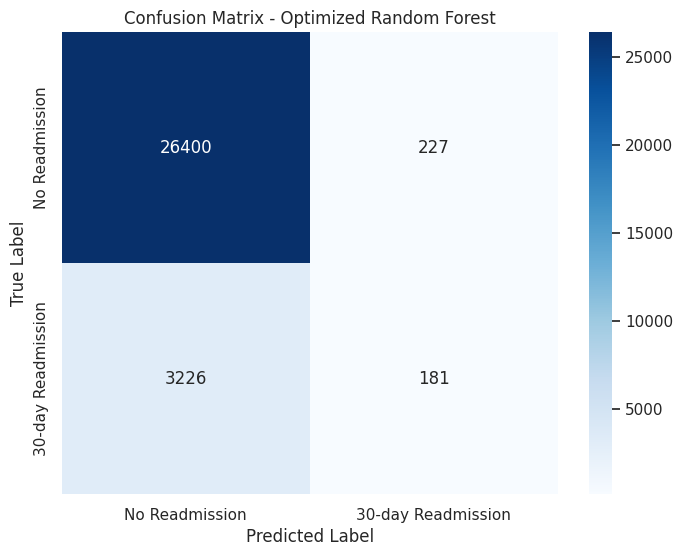

In [23]:

# Create confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Readmission', '30-day Readmission'], 
            yticklabels=['No Readmission', '30-day Readmission'])
plt.title('Confusion Matrix - Optimized Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
# save plot
plt.savefig('confusion_matrix_optimized_rf.png')

In [24]:
print(f"\nConfusion Matrix:")
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")


Confusion Matrix:
True Negatives: 26400
False Positives: 227
False Negatives: 3226
True Positives: 181


In [25]:
study.best_params

{'n_estimators': 819,
 'max_depth': 9,
 'learning_rate': 0.01571828607328239,
 'subsample': 0.8938118110509764,
 'colsample_bytree': 0.7794007533822664,
 'reg_alpha': 0.7725486940264297,
 'reg_lambda': 0.5566573335642219}

 # PyTorch Tabular Implementation



 Now we'll implement the same training pipeline using PyTorch Tabular with neural networks instead of XGBoost. Pytorch Tabular aims to implement suitable neural network architectures for tabular data with ease of use in using other popular frameworks, like Pandas.

In [26]:
# Import PyTorch Tabular
import torch
from pytorch_tabular import TabularModel
from pytorch_tabular.models import CategoryEmbeddingModelConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

print("PyTorch Tabular imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch Tabular imported successfully
PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060 Ti


In [27]:
# Prepare data for PyTorch Tabular
# We'll use the same train/test split as XGBoost but with different preprocessing
print("Preparing data for PyTorch Tabular...")

# Start with the original X_train, X_test, y_train, y_test
# Reset from the original data before one-hot encoding
y = (df_pt['readmitted'] == '<30').astype(int)
X = df_pt.drop(columns=['readmitted'])

X_train_pt, X_test_pt, y_train_pt, y_test_pt = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=1803)

print('PyTorch Tabular - Train size:', X_train_pt.shape, 'Pos rate:', y_train_pt.mean().round(3))
print('PyTorch Tabular - Test size:', X_test_pt.shape, 'Pos rate:', y_test_pt.mean().round(3))

# Clean column names
X_train_pt.columns = [clean_column_name(col) for col in X_train_pt.columns]
X_test_pt.columns = [clean_column_name(col) for col in X_test_pt.columns]

train_df_pt = X_train_pt.copy()
train_df_pt["target"] = y_train_pt.values
print("Data prepared for PyTorch Tabular")

Preparing data for PyTorch Tabular...
PyTorch Tabular - Train size: (70077, 53) Pos rate: 0.113
PyTorch Tabular - Test size: (30034, 53) Pos rate: 0.113
Data prepared for PyTorch Tabular


In [28]:
# Balance training set by random oversampling (same as XGBoost)
print("Balancing training data...")

maj_pt = train_df_pt[train_df_pt['target']==0]
minu_pt = train_df_pt[train_df_pt['target']==1]
minu_upsampled_pt = resample(minu_pt, replace=True, n_samples=len(maj_pt), random_state=1803)
train_bal_df_pt = pd.concat([maj_pt, minu_upsampled_pt])

print('Balanced class counts for PyTorch Tabular:', train_bal_df_pt['target'].value_counts())
print('Balanced training set shape:', train_bal_df_pt.shape)

Balancing training data...
Balanced class counts for PyTorch Tabular: target
0    62127
1    62127
Name: count, dtype: int64
Balanced training set shape: (124254, 54)


In [29]:
# Define categorical and numerical columns for PyTorch Tabular
categorical_cols_pt = [col for col in X_train_pt.columns if X_train_pt[col].dtype == 'object' or X_train_pt[col].dtype.name == 'category']
numerical_cols_pt = [col for col in X_train_pt.columns if X_train_pt[col].dtype != 'object' and X_train_pt[col].dtype.name != 'category']

print(f"Categorical columns ({len(categorical_cols_pt)}): {categorical_cols_pt[:5]}...")
print(f"Numerical columns ({len(numerical_cols_pt)}): {numerical_cols_pt[:5]}...")

# Make sure we have the correct categoricals
categorical_cols_pt = []
numerical_cols_pt = []

for col in X_train_pt.columns:
    if X_train_pt[col].dtype == 'object' or str(X_train_pt[col].dtype) == 'category':
        categorical_cols_pt.append(col)
    else:
        numerical_cols_pt.append(col)

# Dummify categorical columns for PyTorch Tabular
# X_train_pt = pd.get_dummies(X_train_pt, columns=categorical_cols_pt, drop_first=True)
# X_test_pt = pd.get_dummies(X_test_pt, columns=categorical_cols_pt, drop_first=True)

scaler = StandardScaler()
# Normalize numerical columns for PyTorch Tabular
X_train_pt[numerical_cols_pt] = scaler.fit_transform(X_train_pt[numerical_cols_pt])
X_test_pt[numerical_cols_pt] = scaler.transform(X_test_pt[numerical_cols_pt])
X_train_pt, X_test_pt = X_train_pt.align(X_test_pt, join='left', axis=1, fill_value=0)

# Add target column to create complete datasets
train_df_pt = X_train_pt.copy()
train_df_pt['target'] = y_train_pt.values

test_df_pt = X_test_pt.copy()
test_df_pt['target'] = y_test_pt.values

# Configure PyTorch Tabular Data Config
data_config = DataConfig(
    target=['target'],  # Target column
    continuous_cols=numerical_cols_pt,  # Numerical columns
    categorical_cols=categorical_cols_pt,  # Categorical columns
    normalize_continuous_features=True,  # Similar to StandardScaler
)

print("PyTorch Tabular Data Config created successfully")

Categorical columns (37): ['race', 'gender', 'age', 'admission_type_id', 'admission_source_id']...
Numerical columns (16): ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient']...
PyTorch Tabular Data Config created successfully


 * We will use CategoryEmbeddingModelConfig, where categorical data are transformed into high dimensional embeddings.

 * We will go through the process of trying the model incrementally prior to proceeding to hyperparameter tuning.

In [30]:
# Create baseline PyTorch Tabular model configuration
model_config = CategoryEmbeddingModelConfig(
    task="classification",
    layers="128-64-32",  # Neural network architecture
    activation="ReLU",
    dropout=0.1,
    use_batch_norm=True,  # Correct parameter name
    learning_rate=1e-3,
    seed=1803,
    loss="CrossEntropyLoss",  # Use binary cross-entropy for binary classification
)

trainer_config = TrainerConfig(
    batch_size=1024,
    max_epochs=50,
    early_stopping="valid_loss",
    early_stopping_patience=10,
    checkpoints=None,  # Disable checkpoints to avoid loading issues
    load_best=False,   # Don't try to load best model
    progress_bar="none",  # Disable progress bar for cleaner output
    auto_lr_find=False,  # We'll set learning rate manually
    auto_select_gpus=torch.cuda.is_available(),
    seed=1803,
)

optimizer_config = OptimizerConfig()

print("PyTorch Tabular configurations created successfully")

PyTorch Tabular configurations created successfully


In [31]:
# Train baseline PyTorch Tabular model
print("Training baseline PyTorch Tabular model...")

baseline_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)

# Fit the model
baseline_model.fit(train=train_bal_df_pt, validation=test_df_pt)

print("Baseline PyTorch Tabular model training completed")

Training baseline PyTorch Tabular model...


2025-06-27 16:20:56,743 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:20:56,895 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:20:57,244 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:20:58,377 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:20:58,581 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:20:58,596 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 50.5 K | train
1 | _embedding_layer | Embedding1dLayer          | 26.0 K | train
2 | head             | LinearHead                | 66     | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
76.5 K    Trainable params
0         Non-trainable params
76.5 K    Total params
0.306     Total estimated model par

2025-06-27 16:21:36,611 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Baseline PyTorch Tabular model training completed


In [32]:
# Evaluate baseline PyTorch Tabular model
print("Evaluating baseline PyTorch Tabular model...")

# Make predictions
baseline_pred_proba = baseline_model.predict(test_df_pt)
print("Prediction output shape:", baseline_pred_proba.shape)
print("Prediction output columns:", baseline_pred_proba.columns.tolist())

# Get prediction probabilities - use the correct column name
if '1' in baseline_pred_proba.columns:
    baseline_proba_values = baseline_pred_proba['1'].values
elif '1_probability' in baseline_pred_proba.columns:
    baseline_proba_values = baseline_pred_proba['1_probability'].values
else:
    # Try the first numeric column after the identifier columns
    prob_cols = [col for col in baseline_pred_proba.columns if col not in ['patient_nbr', 'target']]
    baseline_proba_values = baseline_pred_proba[prob_cols[0]].values

baseline_pred = (baseline_proba_values > 0.5).astype(int)

# Calculate metrics
baseline_prec = precision_score(y_test_pt, baseline_pred)
baseline_rec = recall_score(y_test_pt, baseline_pred)
baseline_f1 = f1_score(y_test_pt, baseline_pred)
baseline_auc = roc_auc_score(y_test_pt, baseline_proba_values)

print(f"Baseline PyTorch Tabular Performance:")
print(f"Precision: {baseline_prec:.3f}")
print(f"Recall: {baseline_rec:.3f}")
print(f"F1: {baseline_f1:.3f}")
print(f"ROC-AUC: {baseline_auc:.3f}")
print (f"Accuracy: {accuracy_score(y_test_pt, baseline_pred):.3f}")

Evaluating baseline PyTorch Tabular model...
Prediction output shape: (30034, 3)
Prediction output columns: ['target_0_probability', 'target_1_probability', 'target_prediction']
Baseline PyTorch Tabular Performance:
Precision: 0.072
Recall: 0.468
F1: 0.124
ROC-AUC: 0.347
Accuracy: 0.253


 * Results are suboptimal, will proceed to k-fold validation

In [33]:
# Implement 4-fold cross-validation for PyTorch Tabular
from sklearn.model_selection import StratifiedKFold
import pickle
import tempfile
import os
from imblearn.over_sampling import RandomOverSampler
from pytorch_tabular.models.category_embedding.category_embedding_model import CategoryEmbeddingModel
import pytorch_tabular
import torch.nn as nn

In [34]:

class WeightedCategoryEmbeddingModel(CategoryEmbeddingModel):
    """CategoryEmbedding model with weighted loss function for class imbalance"""
    
    def __init__(self, config, **kwargs):
        super().__init__(config, **kwargs)
        # Store class weights for loss function
        self.class_weights = getattr(config, 'class_weights', None)
        
    def loss(self, y_hat, y, tag="train"):
        """Override loss function to use class weights"""
        if self.class_weights is not None:
            # Use weighted CrossEntropyLoss
            loss_fn = nn.CrossEntropyLoss(weight=self.class_weights.to(y_hat.device))
        else:
            # Use standard loss
            loss_fn = nn.CrossEntropyLoss()
            
        if self.hparams.task == "classification":
            computed_loss = loss_fn(y_hat, y.long())
        else:
            computed_loss = loss_fn(y_hat, y)
            
        self.log(
            f"{tag}_loss",
            computed_loss,
            on_epoch=(tag == "valid"),
            on_step=(tag == "train"),
            logger=True,
            prog_bar=True,
        )
        return computed_loss

# Register the model directly in the category_embedding_model module
import pytorch_tabular.models.category_embedding.category_embedding_model as ce_module
ce_module.WeightedCategoryEmbeddingModel = WeightedCategoryEmbeddingModel

In [35]:

# def pytorch_tabular_cv(X_data, y_data, n_folds=4, model_params=None):
#     """
#     Perform cross-validation for PyTorch Tabular model
#     """
#     skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1803)
#     cv_scores = []
    
#     # Combine X and y for easier handling
#     full_data = X_data.copy()
#     full_data['target'] = y_data.values
    
#     for fold, (train_idx, val_idx) in enumerate(skf.split(X_data, y_data)):
#         print(f"Training fold {fold + 1}/{n_folds}...")
        
#         # Split data
#         train_fold = full_data.iloc[train_idx]
#         val_fold = full_data.iloc[val_idx]
        
#         # Balance training fold
#         # Balance training fold using SMOTE from imbalanced-learn
        
#         X_train_fold = train_fold.drop('target', axis=1)
#         y_train_fold = train_fold['target']
        
#         randsamp = RandomOverSampler(random_state=1803+fold)
#         X_train_balanced, y_train_balanced = randsamp.fit_resample(X_train_fold, y_train_fold)
        
#         train_fold_balanced = X_train_balanced.copy()
#         train_fold_balanced['target'] = y_train_balanced
        
#         # Create model configuration
#         if model_params is None:
#             fold_model_config = CategoryEmbeddingModelConfig(
#                 task="classification",
#                 layers="128-64-32",
#                 activation="ReLU", 
#                 dropout=0.1,
#                 use_batch_norm=True,  # Fixed parameter name
#                 learning_rate=1e-4,
#                 seed=1803+fold,
#                 loss="CrossEntropyLoss",  # Use binary cross-entropy for binary classification
#             )
#         else:
#             fold_model_config = CategoryEmbeddingModelConfig(
#                 task="classification",
#                 **model_params,
#                 seed=1803+fold,
#                 loss="CrossEntropyLoss",  # Use binary cross-entropy for binary classification
#             )
        
#         fold_trainer_config = TrainerConfig(
#             batch_size=1024,
#             max_epochs=60,  # Reduced for CV
#             early_stopping="valid_loss",
#             early_stopping_patience=5,
#             checkpoints=None,  # Don't save checkpoints for CV
#             load_best=True,   # Don't try to load best model
#             progress_bar="none",
#             auto_lr_find=False,
#             auto_select_gpus=torch.cuda.is_available(),
#             seed=1803+fold,
#         )
        
#         # Create and train model
#         fold_model = TabularModel(
#             data_config=data_config,
#             model_config=fold_model_config,
#             optimizer_config=optimizer_config,
#             trainer_config=fold_trainer_config,
#         )
        
#         try:
#             # Train model
#             fold_model.fit(train=train_fold_balanced, validation=val_fold)
            
#             # Predict and evaluate
#             val_pred_proba = fold_model.predict(val_fold)
#             # Use correct column name for predictions
#             val_proba_values = val_pred_proba['target_1_probability'].values
#             val_pred = (val_proba_values > 0.5).astype(int)
#             val_accuracy = accuracy_score(val_fold['target'], val_pred)
#             cv_scores.append(val_accuracy)
            
#             print(f"Fold {fold + 1} accuracy score: {val_accuracy:.3f}")
            
#         except Exception as e:
#             print(f"Error in fold {fold + 1}: {e}")
#             cv_scores.append(0.0)  # Add poor score for failed fold
    
#     return cv_scores


# # %%

# # Perform 4-fold cross-validation with baseline model
# print("Performing 4-fold cross-validation with PyTorch Tabular...")
# cv_scores_pt = pytorch_tabular_cv(X_train_pt, y_train_pt, n_folds=4)

# print(f"\nPyTorch Tabular CV Results:")
# print(f"Mean Accuracy: {np.mean(cv_scores_pt):.3f} ± {np.std(cv_scores_pt):.3f}")
# print(f"Individual fold scores: {[f'{score:.3f}' for score in cv_scores_pt]}")

 * Accuracies are suboptimal. Hopefully hyperparameter tuning will enhance this.

 * In this case, layer depths, activation, batch sizes, etc will be modified.

In [36]:
# Hyperparameter tuning for PyTorch Tabular using Optuna
import optuna

# Modify the pytorch_tabular_objective function to fix the _module_src parameter:
def pytorch_tabular_objective(trial):
    """Optuna objective function for PyTorch Tabular hyperparameter optimization"""
    # Suggest hyperparameters
    layers_depth = trial.suggest_int('layers_depth', 2, 4)
    layer_size = trial.suggest_categorical('layer_size', [512, 1024, 2048])
    
    # Create layer string
    if layers_depth == 2:
        layers = f"{layer_size}-{layer_size//2}"
    elif layers_depth == 3:
        layers = f"{layer_size}-{layer_size//2}-{layer_size//4}"
    else:  # layers_depth == 4
        layers = f"{layer_size}-{layer_size//2}-{layer_size//4}-{layer_size//8}"
    
    dropout = trial.suggest_float('dropout', 0.0, 0.2)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [512, 1024, 2048, 4096])
    activation = trial.suggest_categorical('activation', ['ReLU', 'GELU', 'LeakyReLU'])
    
    # Choose balancing strategy
    balance_strategy = trial.suggest_categorical('balance_strategy', ['class_weights'])
    
    # Model parameters
    model_params = {
        'layers': layers,
        'activation': activation,
        'dropout': dropout,
        'use_batch_norm': True,
        'learning_rate': learning_rate,
    }
    
    rng = np.random.default_rng()
    init_state = int(rng.integers(2**16))
    cv_scores = []
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=init_state)
    
    # Combine X and y for easier handling
    full_data = X_train_pt.copy()
    full_data['target'] = y_train_pt.values

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_pt, y_train_pt)):
        # Split data
        train_fold = full_data.iloc[train_idx]
        val_fold = full_data.iloc[val_idx]
        
        # Use original imbalanced data
        train_fold_balanced = train_fold.copy()
        y_fold = train_fold['target']
        
        # Compute class weights if needed

        
        # Create standard model config - FIX HERE: Use CategoryEmbeddingModelConfig directly
    # Modified model config with correct module reference
        # Create standard model config with correct loss specification
        fold_model_config = CategoryEmbeddingModelConfig(
            task="classification",
            **model_params,
            seed=init_state+fold,
            # Specify loss as a string, not as an instance
            loss="CrossEntropyLoss"  # Keep this as a string
        )

        # Add class weights as a custom attribute
        class_weights = None
        if balance_strategy == 'class_weights':
            class_counts = np.bincount(y_fold)
            total_samples = len(y_fold)
            
            # Calculate inverse frequency weights
            weight_for_0 = total_samples / (2.0 * class_counts[0])
            weight_for_1 = total_samples / (2.0 * class_counts[1])
            class_weights = torch.tensor([weight_for_0, weight_for_1], dtype=torch.float32)
            print(f"Fold {fold + 1} - Class weights: {class_weights.tolist()}")
            
            # Don't set loss as an instance - just add class_weights as an attribute
            setattr(fold_model_config, 'class_weights', class_weights)

        # Add class weights as a custom attribute
        setattr(fold_model_config, 'class_weights', class_weights)
        
        fold_trainer_config = TrainerConfig(
            batch_size=batch_size,
            max_epochs=20,
            early_stopping="valid_loss",
            early_stopping_patience=3,
            checkpoints=None,
            load_best=False,
            progress_bar="none",
            auto_lr_find=False,
            auto_select_gpus=torch.cuda.is_available(),
            seed=1803+fold,
        )
        
        # Create and train model
        fold_model = TabularModel(
            data_config=data_config,
            model_config=fold_model_config,
            optimizer_config=optimizer_config,
            trainer_config=fold_trainer_config,
        )
        
        try:
            # Train model
            fold_model.fit(train=train_fold_balanced, validation=val_fold)
            
            # Predict and evaluate
            val_pred_proba = fold_model.predict(val_fold)
            val_proba_values = val_pred_proba['target_1_probability'].values
            val_pred = (val_proba_values > 0.5).astype(int)
            val_accuracy = accuracy_score(val_fold['target'], val_pred)
            
            # Also log F1 score for imbalanced data
            val_f1 = f1_score(val_fold['target'], val_pred)
            print(f"Fold {fold + 1} - Strategy: {balance_strategy}, Val Accuracy: {val_accuracy:.3f}, Val F1: {val_f1:.3f}")
            cv_scores.append(val_accuracy)
            
        except Exception as e:
            print(f"Error in fold {fold}: {e}")
            return 0.0
    
    return np.mean(cv_scores) if len(cv_scores) > 0 else 0.0

# Run Optuna optimization for PyTorch Tabular (smaller trial for speed)
print("Starting Optuna hyperparameter optimization for PyTorch Tabular...")
study_pt = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=1803)
)

study_pt.optimize(
    pytorch_tabular_objective, 
    n_trials=20,  
    show_progress_bar=True,
)

# Print optimization results
print(f"\nPyTorch Tabular Optimization completed!")
print(f"Best parameters: {study_pt.best_params}")
print(f"Best CV accuracy score: {study_pt.best_value:.4f}")

[I 2025-06-27 16:21:37,995] A new study created in memory with name: no-name-3141ae18-959c-41dd-b50f-ee6f073f211c


Starting Optuna hyperparameter optimization for PyTorch Tabular...


  0%|          | 0/20 [00:00<?, ?it/s]

Fold 1 - Class weights: [0.5639768242835999, 4.407665252685547]


2025-06-27 16:21:38,036 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:21:38,074 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:21:38,228 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:21:38,714 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:21:38,838 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:21:38,841 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:21:38,843 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:21:38,846 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:21:38,852 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:21:38,862 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 288 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.6 K | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
314 K     Trainable params
0         Non-trainable params
314 K     Total params
1.259     Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:21:51,508 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 1 - Strategy: class_weights, Val Accuracy: 0.879, Val F1: 0.132
Fold 2 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:21:52,096 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:21:52,116 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:21:52,253 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:21:52,729 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:21:52,851 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:21:52,854 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:21:52,857 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:21:52,859 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:21:52,865 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:21:52,875 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 289 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.6 K | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
315 K     Trainable params
0         Non-trainable params
315 K     Total params
1.261     Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:22:03,545 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 2 - Strategy: class_weights, Val Accuracy: 0.881, Val F1: 0.107
Fold 3 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:22:03,962 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:22:03,983 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:22:04,121 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:22:04,597 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:22:04,719 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:04,722 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:04,724 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:04,726 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:04,732 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:22:04,742 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 287 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.1 K | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
313 K     Trainable params
0         Non-trainable params
313 K     Total params
1.253     Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:22:15,462 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 3 - Strategy: class_weights, Val Accuracy: 0.880, Val F1: 0.130
Fold 4 - Class weights: [0.56397545337677, 4.407749176025391]


2025-06-27 16:22:15,875 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:22:15,895 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:22:16,032 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:22:16,501 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:22:16,624 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:16,628 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:16,630 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:16,633 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:16,794 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:22:16,803 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 286 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.1 K | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
311 K     Trainable params
0         Non-trainable params
311 K     Total params
1.247     Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:22:27,561 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 4 - Strategy: class_weights, Val Accuracy: 0.884, Val F1: 0.118
[I 2025-06-27 16:22:27,954] Trial 0 finished with value: 0.8810879702754557 and parameters: {'layers_depth': 2, 'layer_size': 512, 'dropout': 0.130934935703331, 'learning_rate': 0.0006202859954507495, 'batch_size': 512, 'activation': 'GELU', 'balance_strategy': 'class_weights'}. Best is trial 0 with value: 0.8810879702754557.
Fold 1 - Class weights: [0.5639768242835999, 4.407665252685547]


2025-06-27 16:22:27,987 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:22:28,008 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:22:28,146 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:22:28,619 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:22:28,743 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:28,757 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:28,769 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:28,773 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:28,788 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:22:28,798 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 2.7 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.2 K | train
2 | head             | LinearHead                | 2.0 K  | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.003    Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:22:36,810 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 1 - Strategy: class_weights, Val Accuracy: 0.884, Val F1: 0.068
Fold 2 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:22:37,408 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:22:37,428 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:22:37,565 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:22:38,039 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:22:38,162 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:38,175 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:38,187 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:38,193 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:38,208 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:22:38,218 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 2.7 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.5 K | train
2 | head             | LinearHead                | 2.0 K  | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.996    Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:22:46,798 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 2 - Strategy: class_weights, Val Accuracy: 0.868, Val F1: 0.155
Fold 3 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:22:47,382 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:22:47,402 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:22:47,540 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:22:48,009 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:22:48,132 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:48,146 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:48,157 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:48,162 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:48,177 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:22:48,187 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 2.7 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.1 K | train
2 | head             | LinearHead                | 2.0 K  | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.002    Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:22:55,659 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 3 - Strategy: class_weights, Val Accuracy: 0.878, Val F1: 0.124
Fold 4 - Class weights: [0.56397545337677, 4.407749176025391]


2025-06-27 16:22:56,245 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:22:56,266 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:22:56,406 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:22:56,876 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:22:56,998 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:57,012 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:57,023 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:57,029 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:22:57,045 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:22:57,055 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 2.7 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.5 K | train
2 | head             | LinearHead                | 2.0 K  | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.004    Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:23:04,448 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 4 - Strategy: class_weights, Val Accuracy: 0.879, Val F1: 0.155
[I 2025-06-27 16:23:05,011] Trial 1 finished with value: 0.8774061897506713 and parameters: {'layers_depth': 2, 'layer_size': 2048, 'dropout': 0.06008164849880271, 'learning_rate': 0.004656290091181584, 'batch_size': 4096, 'activation': 'GELU', 'balance_strategy': 'class_weights'}. Best is trial 0 with value: 0.8810879702754557.
Fold 1 - Class weights: [0.5639768242835999, 4.407665252685547]


2025-06-27 16:23:05,048 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:23:05,068 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:23:05,206 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:23:05,685 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:23:05,814 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:23:05,824 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 288 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.4 K | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
314 K     Trainable params
0         Non-trainable params
314 K     Total params
1.258     Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


2025-06-27 16:23:28,253 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 1 - Strategy: class_weights, Val Accuracy: 0.886, Val F1: 0.069
Fold 2 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:23:28,618 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:23:28,638 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:23:28,775 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:23:29,243 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:23:29,369 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:23:29,379 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 288 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.4 K | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
314 K     Trainable params
0         Non-trainable params
314 K     Total params
1.256     Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:23:46,283 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 2 - Strategy: class_weights, Val Accuracy: 0.882, Val F1: 0.111
Fold 3 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:23:46,650 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:23:46,672 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:23:46,811 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:23:47,283 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:23:47,411 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:23:47,422 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 287 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.3 K | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
313 K     Trainable params
0         Non-trainable params
313 K     Total params
1.254     Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:24:07,638 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 3 - Strategy: class_weights, Val Accuracy: 0.884, Val F1: 0.079
Fold 4 - Class weights: [0.56397545337677, 4.407749176025391]


2025-06-27 16:24:08,000 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:24:08,022 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:24:08,161 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:24:08,631 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:24:08,758 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:24:08,768 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 287 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.4 K | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
313 K     Trainable params
0         Non-trainable params
313 K     Total params
1.254     Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


2025-06-27 16:24:31,806 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 4 - Strategy: class_weights, Val Accuracy: 0.886, Val F1: 0.083
[I 2025-06-27 16:24:32,185] Trial 2 finished with value: 0.8842416011279078 and parameters: {'layers_depth': 2, 'layer_size': 512, 'dropout': 0.1847037348502109, 'learning_rate': 0.0002566421941195333, 'batch_size': 4096, 'activation': 'ReLU', 'balance_strategy': 'class_weights'}. Best is trial 2 with value: 0.8842416011279078.
Fold 1 - Class weights: [0.5639768242835999, 4.407665252685547]


2025-06-27 16:24:32,220 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:24:32,240 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:24:32,381 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:24:32,868 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:24:32,992 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:24:32,996 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:24:32,998 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:24:33,000 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:24:33,006 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:24:33,016 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 288 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
313 K     Trainable params
0         Non-trainable params
313 K     Total params
1.254     Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:24:50,085 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 1 - Strategy: class_weights, Val Accuracy: 0.883, Val F1: 0.113
Fold 2 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:24:50,527 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:24:50,548 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:24:50,688 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:24:51,174 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:24:51,299 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:24:51,302 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:24:51,305 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:24:51,307 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:24:51,313 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:24:51,324 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 287 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.4 K | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
313 K     Trainable params
0         Non-trainable params
313 K     Total params
1.254     Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:25:11,273 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 2 - Strategy: class_weights, Val Accuracy: 0.881, Val F1: 0.117
Fold 3 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:25:11,705 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:25:11,727 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:25:11,868 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:25:12,376 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:25:12,506 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:25:12,509 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:25:12,512 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:25:12,514 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:25:12,520 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:25:12,530 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 287 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.4 K | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
313 K     Trainable params
0         Non-trainable params
313 K     Total params
1.252     Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:25:30,999 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 3 - Strategy: class_weights, Val Accuracy: 0.883, Val F1: 0.087
Fold 4 - Class weights: [0.56397545337677, 4.407749176025391]


2025-06-27 16:25:31,450 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:25:31,479 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:25:31,626 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:25:32,126 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:25:32,257 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:25:32,261 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:25:32,263 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:25:32,266 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:25:32,271 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:25:32,283 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 288 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.6 K | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
314 K     Trainable params
0         Non-trainable params
314 K     Total params
1.259     Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:25:50,890 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 4 - Strategy: class_weights, Val Accuracy: 0.882, Val F1: 0.109
[I 2025-06-27 16:25:51,337] Trial 3 finished with value: 0.8823579710652049 and parameters: {'layers_depth': 2, 'layer_size': 512, 'dropout': 0.13411232306981227, 'learning_rate': 0.00027147832847446943, 'batch_size': 512, 'activation': 'GELU', 'balance_strategy': 'class_weights'}. Best is trial 2 with value: 0.8842416011279078.
Fold 1 - Class weights: [0.5639768242835999, 4.407665252685547]


2025-06-27 16:25:51,374 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:25:51,396 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:25:51,548 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:25:52,050 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:25:52,193 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:25:52,204 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 834 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.4 K | train
2 | head             | LinearHead                | 1.0 K  | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
861 K     Trainable params
0         Non-trainable params
861 K     Total params
3.444     Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:26:02,679 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 1 - Strategy: class_weights, Val Accuracy: 0.876, Val F1: 0.152
Fold 2 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:26:03,310 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:26:03,331 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:26:03,483 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:26:04,027 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:26:04,181 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:26:04,192 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 837 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.3 K | train
2 | head             | LinearHead                | 1.0 K  | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
864 K     Trainable params
0         Non-trainable params
864 K     Total params
3.456     Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:26:15,327 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 2 - Strategy: class_weights, Val Accuracy: 0.881, Val F1: 0.126
Fold 3 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:26:15,937 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:26:15,961 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:26:16,119 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:26:16,668 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:26:16,831 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:26:16,841 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 837 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.2 K | train
2 | head             | LinearHead                | 1.0 K  | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
863 K     Trainable params
0         Non-trainable params
863 K     Total params
3.456     Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:26:27,696 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 3 - Strategy: class_weights, Val Accuracy: 0.882, Val F1: 0.119
Fold 4 - Class weights: [0.56397545337677, 4.407749176025391]


2025-06-27 16:26:28,255 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:26:28,280 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:26:28,432 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:26:28,950 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:26:29,097 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:26:29,107 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 836 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.3 K | train
2 | head             | LinearHead                | 1.0 K  | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
863 K     Trainable params
0         Non-trainable params
863 K     Total params
3.452     Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:26:42,146 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 4 - Strategy: class_weights, Val Accuracy: 0.874, Val F1: 0.153
[I 2025-06-27 16:26:42,722] Trial 4 finished with value: 0.8782482411138227 and parameters: {'layers_depth': 2, 'layer_size': 1024, 'dropout': 0.0760457917002193, 'learning_rate': 0.00043595297361509016, 'batch_size': 512, 'activation': 'ReLU', 'balance_strategy': 'class_weights'}. Best is trial 2 with value: 0.8842416011279078.
Fold 1 - Class weights: [0.5639768242835999, 4.407665252685547]


2025-06-27 16:26:42,758 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:26:42,781 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:26:42,929 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:26:43,490 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:26:43,635 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:26:43,649 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:26:43,662 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:26:43,667 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:26:43,684 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:26:43,696 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 2.7 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.3 K | train
2 | head             | LinearHead                | 2.0 K  | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.003    Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:26:54,253 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 1 - Strategy: class_weights, Val Accuracy: 0.880, Val F1: 0.125
Fold 2 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:26:55,013 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:26:55,037 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:26:55,200 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:26:55,729 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:26:55,877 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:26:55,892 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:26:55,904 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:26:55,911 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:26:55,928 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:26:55,938 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 2.7 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.1 K | train
2 | head             | LinearHead                | 2.0 K  | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.977    Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:27:11,058 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 2 - Strategy: class_weights, Val Accuracy: 0.880, Val F1: 0.141
Fold 3 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:27:11,907 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:27:11,930 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:27:12,110 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:27:12,668 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:27:12,815 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:27:12,830 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:27:12,847 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:27:12,855 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:27:12,880 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:27:12,893 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 2.7 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.5 K | train
2 | head             | LinearHead                | 2.0 K  | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.020    Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:27:24,798 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 3 - Strategy: class_weights, Val Accuracy: 0.883, Val F1: 0.129
Fold 4 - Class weights: [0.56397545337677, 4.407749176025391]


2025-06-27 16:27:25,643 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:27:25,667 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:27:25,843 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:27:26,417 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:27:26,561 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:27:26,575 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:27:26,589 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:27:26,594 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:27:26,611 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:27:26,623 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 2.7 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.3 K | train
2 | head             | LinearHead                | 2.0 K  | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.987    Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:27:43,059 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 4 - Strategy: class_weights, Val Accuracy: 0.882, Val F1: 0.134
[I 2025-06-27 16:27:43,863] Trial 5 finished with value: 0.8810308836902713 and parameters: {'layers_depth': 2, 'layer_size': 2048, 'dropout': 0.14069820916643896, 'learning_rate': 0.0001091850104643658, 'batch_size': 2048, 'activation': 'GELU', 'balance_strategy': 'class_weights'}. Best is trial 2 with value: 0.8842416011279078.
Fold 1 - Class weights: [0.5639768242835999, 4.407665252685547]


2025-06-27 16:27:43,904 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:27:43,926 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:27:44,123 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:27:44,678 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:27:44,849 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:27:44,860 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 322 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.4 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
347 K     Trainable params
0         Non-trainable params
347 K     Total params
1.391     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:28:09,010 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 1 - Strategy: class_weights, Val Accuracy: 0.886, Val F1: 0.041
Fold 2 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:28:09,519 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:28:09,546 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:28:09,694 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:28:10,216 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:28:10,363 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:28:10,374 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 321 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.6 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
347 K     Trainable params
0         Non-trainable params
347 K     Total params
1.389     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:28:42,022 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 2 - Strategy: class_weights, Val Accuracy: 0.886, Val F1: 0.043
Fold 3 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:28:42,506 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:28:42,535 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:28:42,689 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:28:43,200 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:28:43,343 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:28:43,353 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 320 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
346 K     Trainable params
0         Non-trainable params
346 K     Total params
1.385     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:29:19,702 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 3 - Strategy: class_weights, Val Accuracy: 0.886, Val F1: 0.056
Fold 4 - Class weights: [0.56397545337677, 4.407749176025391]


2025-06-27 16:29:20,164 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:29:20,185 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:29:20,335 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:29:20,848 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:29:20,989 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:29:21,000 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 320 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.5 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
346 K     Trainable params
0         Non-trainable params
346 K     Total params
1.387     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:29:46,511 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 4 - Strategy: class_weights, Val Accuracy: 0.886, Val F1: 0.066
[I 2025-06-27 16:29:46,987] Trial 6 finished with value: 0.8859968309683863 and parameters: {'layers_depth': 3, 'layer_size': 512, 'dropout': 0.196752334642426, 'learning_rate': 0.00031762858931761676, 'batch_size': 512, 'activation': 'LeakyReLU', 'balance_strategy': 'class_weights'}. Best is trial 6 with value: 0.8859968309683863.
Fold 1 - Class weights: [0.5639768242835999, 4.407665252685547]


2025-06-27 16:29:47,023 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:29:47,044 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:29:47,190 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:29:47,696 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:29:47,828 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:29:47,834 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:29:47,839 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:29:47,842 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:29:47,844 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:29:47,847 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:29:47,851 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:29:47,854 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:29:47,860 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:29:47,871 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 1.0 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.4 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.112     Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-27 16:29:55,043 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 1 - Strategy: class_weights, Val Accuracy: 0.876, Val F1: 0.117
Fold 2 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:29:55,583 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:29:55,605 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:29:55,755 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:29:56,266 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:29:56,400 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:29:56,406 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:29:56,411 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:29:56,414 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:29:56,416 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:29:56,419 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:29:56,423 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:29:56,426 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:29:56,431 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:29:56,443 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 1.0 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.6 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.125     Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-27 16:30:03,682 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 2 - Strategy: class_weights, Val Accuracy: 0.877, Val F1: 0.113
Fold 3 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:30:04,220 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:30:04,241 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:30:04,389 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:30:04,900 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:30:05,033 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:05,039 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:05,044 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:05,047 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:05,049 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:05,052 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:05,057 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:05,059 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:05,067 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:30:05,080 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 1.0 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.2 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.108     Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-27 16:30:12,105 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 3 - Strategy: class_weights, Val Accuracy: 0.877, Val F1: 0.119
Fold 4 - Class weights: [0.56397545337677, 4.407749176025391]


2025-06-27 16:30:12,602 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:30:12,623 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:30:12,772 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:30:13,293 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:30:13,430 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:13,436 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:13,442 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:13,445 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:13,446 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:13,451 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:13,456 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:13,458 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:13,465 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:30:13,476 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 1.0 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.3 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.112     Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-27 16:30:20,757 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 4 - Strategy: class_weights, Val Accuracy: 0.879, Val F1: 0.125
[I 2025-06-27 16:30:21,287] Trial 7 finished with value: 0.8773920286741519 and parameters: {'layers_depth': 4, 'layer_size': 1024, 'dropout': 0.07049111756036855, 'learning_rate': 0.0011814887626192007, 'batch_size': 2048, 'activation': 'GELU', 'balance_strategy': 'class_weights'}. Best is trial 6 with value: 0.8859968309683863.
Fold 1 - Class weights: [0.5639768242835999, 4.407665252685547]


2025-06-27 16:30:21,324 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:30:21,346 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:30:21,505 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:30:22,023 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:30:22,159 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:22,173 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:22,186 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:22,190 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:22,207 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:30:22,218 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 2.7 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.4 K | train
2 | head             | LinearHead                | 2.0 K  | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.987    Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:30:31,127 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 1 - Strategy: class_weights, Val Accuracy: 0.882, Val F1: 0.074
Fold 2 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:30:31,831 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:30:31,853 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:30:32,005 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:30:32,528 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:30:32,668 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:32,682 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:32,694 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:32,699 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:32,715 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:30:32,725 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 2.7 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.4 K | train
2 | head             | LinearHead                | 2.0 K  | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.003    Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:30:40,225 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 2 - Strategy: class_weights, Val Accuracy: 0.881, Val F1: 0.102
Fold 3 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:30:40,973 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:30:40,998 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:30:41,160 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:30:41,677 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:30:41,817 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:41,832 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:41,848 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:41,853 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:41,869 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:30:41,880 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 2.7 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.4 K | train
2 | head             | LinearHead                | 2.0 K  | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.995    Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:30:49,255 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 3 - Strategy: class_weights, Val Accuracy: 0.863, Val F1: 0.231
Fold 4 - Class weights: [0.56397545337677, 4.407749176025391]


2025-06-27 16:30:49,927 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:30:49,948 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:30:50,107 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:30:50,617 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:30:50,750 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:50,764 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:50,776 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:50,781 - {pytorch_tabular.utils.nn_utils:21} - WARNING - Kaiming initialization is only           
recommended for ReLU and LeakyReLU.

2025-06-27 16:30:50,796 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:30:50,807 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 2.7 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.2 K | train
2 | head             | LinearHead                | 2.0 K  | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.011    Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


2025-06-27 16:30:59,685 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 4 - Strategy: class_weights, Val Accuracy: 0.882, Val F1: 0.126
[I 2025-06-27 16:31:00,325] Trial 8 finished with value: 0.8771065395470176 and parameters: {'layers_depth': 2, 'layer_size': 2048, 'dropout': 0.19727895472694268, 'learning_rate': 0.005492754378281531, 'batch_size': 2048, 'activation': 'GELU', 'balance_strategy': 'class_weights'}. Best is trial 6 with value: 0.8859968309683863.
Fold 1 - Class weights: [0.5639768242835999, 4.407665252685547]


2025-06-27 16:31:00,362 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:31:00,383 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:31:00,531 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:31:01,041 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:31:01,193 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:31:01,203 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 969 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.3 K | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
994 K     Trainable params
0         Non-trainable params
994 K     Total params
3.979     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:31:08,148 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 1 - Strategy: class_weights, Val Accuracy: 0.880, Val F1: 0.094
Fold 2 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:31:08,669 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:31:08,692 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:31:08,840 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:31:09,350 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:31:09,499 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:31:09,508 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 969 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.5 K | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
995 K     Trainable params
0         Non-trainable params
995 K     Total params
3.980     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:31:18,044 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 2 - Strategy: class_weights, Val Accuracy: 0.885, Val F1: 0.036
Fold 3 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:31:18,538 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:31:18,562 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:31:18,710 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:31:19,216 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:31:19,365 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:31:19,376 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 968 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
993 K     Trainable params
0         Non-trainable params
993 K     Total params
3.974     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:31:27,903 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 3 - Strategy: class_weights, Val Accuracy: 0.882, Val F1: 0.061
Fold 4 - Class weights: [0.56397545337677, 4.407749176025391]


2025-06-27 16:31:28,406 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:31:28,427 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:31:28,574 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:31:29,087 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:31:29,239 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:31:29,249 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 971 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.7 K | train
2 | head             | LinearHead                | 514    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
997 K     Trainable params
0         Non-trainable params
997 K     Total params
3.989     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:31:37,901 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 4 - Strategy: class_weights, Val Accuracy: 0.876, Val F1: 0.100
[I 2025-06-27 16:31:38,416] Trial 9 finished with value: 0.880845373262063 and parameters: {'layers_depth': 3, 'layer_size': 1024, 'dropout': 0.08138866062718597, 'learning_rate': 0.008606047732852118, 'batch_size': 2048, 'activation': 'LeakyReLU', 'balance_strategy': 'class_weights'}. Best is trial 6 with value: 0.8859968309683863.
Fold 1 - Class weights: [0.5639768242835999, 4.407665252685547]


2025-06-27 16:31:38,463 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:31:38,484 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:31:38,632 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:31:39,145 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:31:39,284 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:31:39,294 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 330 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.3 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
355 K     Trainable params
0         Non-trainable params
355 K     Total params
1.422     Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-27 16:31:45,956 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 1 - Strategy: class_weights, Val Accuracy: 0.877, Val F1: 0.133
Fold 2 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:31:46,462 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:31:46,483 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:31:46,628 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:31:47,142 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:31:47,283 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:31:47,293 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 328 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.3 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
353 K     Trainable params
0         Non-trainable params
353 K     Total params
1.415     Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-27 16:31:54,379 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 2 - Strategy: class_weights, Val Accuracy: 0.871, Val F1: 0.153
Fold 3 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:31:54,820 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:31:54,841 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:31:54,988 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:31:55,504 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:31:55,645 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:31:55,656 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 331 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.5 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
356 K     Trainable params
0         Non-trainable params
356 K     Total params
1.427     Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-27 16:32:02,262 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 3 - Strategy: class_weights, Val Accuracy: 0.876, Val F1: 0.135
Fold 4 - Class weights: [0.56397545337677, 4.407749176025391]


2025-06-27 16:32:02,708 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:32:02,729 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:32:02,877 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:32:03,390 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:32:03,532 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:32:03,542 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 330 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.2 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
355 K     Trainable params
0         Non-trainable params
355 K     Total params
1.423     Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-27 16:32:12,194 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 4 - Strategy: class_weights, Val Accuracy: 0.865, Val F1: 0.138
[I 2025-06-27 16:32:12,674] Trial 10 finished with value: 0.8723546227761587 and parameters: {'layers_depth': 4, 'layer_size': 512, 'dropout': 0.004474065927652898, 'learning_rate': 0.0016984491906698294, 'batch_size': 1024, 'activation': 'LeakyReLU', 'balance_strategy': 'class_weights'}. Best is trial 6 with value: 0.8859968309683863.
Fold 1 - Class weights: [0.5639768242835999, 4.407665252685547]


2025-06-27 16:32:12,721 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:32:12,742 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:32:12,899 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:32:13,418 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:32:13,559 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:32:13,570 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 321 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.2 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
346 K     Trainable params
0         Non-trainable params
346 K     Total params
1.388     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:32:21,273 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 1 - Strategy: class_weights, Val Accuracy: 0.886, Val F1: 0.030
Fold 2 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:32:21,857 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:32:21,878 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:32:22,023 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:32:22,535 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:32:22,675 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:32:22,686 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 320 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.3 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
346 K     Trainable params
0         Non-trainable params
346 K     Total params
1.386     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:32:30,403 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 2 - Strategy: class_weights, Val Accuracy: 0.887, Val F1: 0.039
Fold 3 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:32:30,817 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:32:30,838 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:32:30,987 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:32:31,502 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:32:31,802 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:32:31,812 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 319 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.3 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
345 K     Trainable params
0         Non-trainable params
345 K     Total params
1.382     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


2025-06-27 16:32:56,911 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 3 - Strategy: class_weights, Val Accuracy: 0.885, Val F1: 0.056
Fold 4 - Class weights: [0.56397545337677, 4.407749176025391]


2025-06-27 16:32:57,338 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:32:57,359 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:32:57,505 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:32:58,017 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:32:58,161 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:32:58,171 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 322 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.3 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
347 K     Trainable params
0         Non-trainable params
347 K     Total params
1.390     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


2025-06-27 16:33:23,728 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 4 - Strategy: class_weights, Val Accuracy: 0.885, Val F1: 0.049
[I 2025-06-27 16:33:24,129] Trial 11 finished with value: 0.8858398536513912 and parameters: {'layers_depth': 3, 'layer_size': 512, 'dropout': 0.1840768822295468, 'learning_rate': 0.00017122745412351167, 'batch_size': 4096, 'activation': 'ReLU', 'balance_strategy': 'class_weights'}. Best is trial 6 with value: 0.8859968309683863.
Fold 1 - Class weights: [0.5639768242835999, 4.407665252685547]


2025-06-27 16:33:24,178 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:33:24,198 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:33:24,346 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:33:24,859 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:33:25,000 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:33:25,010 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 320 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.4 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
346 K     Trainable params
0         Non-trainable params
346 K     Total params
1.386     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


2025-06-27 16:33:50,458 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 1 - Strategy: class_weights, Val Accuracy: 0.885, Val F1: 0.039
Fold 2 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:33:50,883 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:33:50,903 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:33:51,052 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:33:51,569 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:33:51,714 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:33:51,724 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 322 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.5 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
347 K     Trainable params
0         Non-trainable params
347 K     Total params
1.391     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


2025-06-27 16:34:17,330 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 2 - Strategy: class_weights, Val Accuracy: 0.886, Val F1: 0.034
Fold 3 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:34:17,804 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:34:17,825 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:34:17,975 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:34:18,548 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:34:18,688 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:34:18,699 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 322 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.6 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
347 K     Trainable params
0         Non-trainable params
347 K     Total params
1.391     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:34:30,608 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 3 - Strategy: class_weights, Val Accuracy: 0.887, Val F1: 0.038
Fold 4 - Class weights: [0.56397545337677, 4.407749176025391]


2025-06-27 16:34:31,047 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:34:31,069 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:34:31,220 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:34:31,750 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:34:31,897 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:34:31,907 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 320 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.2 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
346 K     Trainable params
0         Non-trainable params
346 K     Total params
1.386     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


2025-06-27 16:34:57,655 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 4 - Strategy: class_weights, Val Accuracy: 0.886, Val F1: 0.052
[I 2025-06-27 16:34:58,064] Trial 12 finished with value: 0.8857399881694004 and parameters: {'layers_depth': 3, 'layer_size': 512, 'dropout': 0.16231088170172123, 'learning_rate': 0.00010918737753282148, 'batch_size': 4096, 'activation': 'LeakyReLU', 'balance_strategy': 'class_weights'}. Best is trial 6 with value: 0.8859968309683863.
Fold 1 - Class weights: [0.5639768242835999, 4.407665252685547]


2025-06-27 16:34:58,112 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:34:58,133 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:34:58,279 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:34:58,786 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:34:58,924 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:34:58,934 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 318 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.0 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
344 K     Trainable params
0         Non-trainable params
344 K     Total params
1.377     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


2025-06-27 16:35:32,566 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 1 - Strategy: class_weights, Val Accuracy: 0.886, Val F1: 0.069
Fold 2 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:35:32,995 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:35:33,016 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:35:33,164 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:35:33,676 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:35:33,815 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:35:33,827 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 320 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.3 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
346 K     Trainable params
0         Non-trainable params
346 K     Total params
1.386     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:36:01,890 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 2 - Strategy: class_weights, Val Accuracy: 0.887, Val F1: 0.048
Fold 3 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:36:02,376 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:36:02,398 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:36:02,544 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:36:03,051 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:36:03,192 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:36:03,202 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 321 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.4 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
347 K     Trainable params
0         Non-trainable params
347 K     Total params
1.389     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


2025-06-27 16:36:36,588 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 3 - Strategy: class_weights, Val Accuracy: 0.886, Val F1: 0.040
Fold 4 - Class weights: [0.56397545337677, 4.407749176025391]


2025-06-27 16:36:37,036 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:36:37,061 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:36:37,233 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:36:37,737 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:36:37,874 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:36:37,884 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 323 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.7 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
348 K     Trainable params
0         Non-trainable params
348 K     Total params
1.396     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:37:07,653 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 4 - Strategy: class_weights, Val Accuracy: 0.885, Val F1: 0.043
[I 2025-06-27 16:37:08,073] Trial 13 finished with value: 0.8859397541573258 and parameters: {'layers_depth': 3, 'layer_size': 512, 'dropout': 0.17153217409298116, 'learning_rate': 0.00022667101955402923, 'batch_size': 1024, 'activation': 'ReLU', 'balance_strategy': 'class_weights'}. Best is trial 6 with value: 0.8859968309683863.
Fold 1 - Class weights: [0.5639768242835999, 4.407665252685547]


2025-06-27 16:37:08,126 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:37:08,147 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:37:08,292 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:37:08,816 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:37:08,958 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:37:08,968 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 320 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.3 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
346 K     Trainable params
0         Non-trainable params
346 K     Total params
1.386     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:37:28,563 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 1 - Strategy: class_weights, Val Accuracy: 0.885, Val F1: 0.075
Fold 2 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:37:28,997 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:37:29,019 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:37:29,170 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:37:29,701 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:37:29,844 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:37:29,854 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 321 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.4 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
347 K     Trainable params
0         Non-trainable params
347 K     Total params
1.389     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:37:46,524 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 2 - Strategy: class_weights, Val Accuracy: 0.884, Val F1: 0.063
Fold 3 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:37:47,023 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:37:47,043 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:37:47,187 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:37:47,692 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:37:47,829 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:37:47,839 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 321 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.2 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
346 K     Trainable params
0         Non-trainable params
346 K     Total params
1.388     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:38:07,787 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 3 - Strategy: class_weights, Val Accuracy: 0.883, Val F1: 0.060
Fold 4 - Class weights: [0.56397545337677, 4.407749176025391]


2025-06-27 16:38:08,285 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:38:08,306 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:38:08,451 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:38:08,983 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:38:09,130 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:38:09,141 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 322 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.5 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
347 K     Trainable params
0         Non-trainable params
347 K     Total params
1.391     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:38:29,350 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 4 - Strategy: class_weights, Val Accuracy: 0.886, Val F1: 0.056
[I 2025-06-27 16:38:29,770] Trial 14 finished with value: 0.8845840896876216 and parameters: {'layers_depth': 3, 'layer_size': 512, 'dropout': 0.16192541973684976, 'learning_rate': 0.0005374553980833491, 'batch_size': 1024, 'activation': 'LeakyReLU', 'balance_strategy': 'class_weights'}. Best is trial 6 with value: 0.8859968309683863.
Fold 1 - Class weights: [0.5639768242835999, 4.407665252685547]


2025-06-27 16:38:29,818 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:38:29,839 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:38:29,985 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:38:30,495 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:38:30,637 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:38:30,647 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 328 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.6 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
354 K     Trainable params
0         Non-trainable params
354 K     Total params
1.417     Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-27 16:38:54,149 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 1 - Strategy: class_weights, Val Accuracy: 0.886, Val F1: 0.023
Fold 2 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:38:54,622 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:38:54,643 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:38:54,791 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:38:55,294 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:38:55,432 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:38:55,443 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 330 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.1 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
355 K     Trainable params
0         Non-trainable params
355 K     Total params
1.421     Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-27 16:39:24,391 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 2 - Strategy: class_weights, Val Accuracy: 0.886, Val F1: 0.044
Fold 3 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:39:24,852 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:39:24,874 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:39:25,026 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:39:25,537 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:39:25,695 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:39:25,706 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 330 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.3 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
355 K     Trainable params
0         Non-trainable params
355 K     Total params
1.424     Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-27 16:39:50,475 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 3 - Strategy: class_weights, Val Accuracy: 0.886, Val F1: 0.051
Fold 4 - Class weights: [0.56397545337677, 4.407749176025391]


2025-06-27 16:39:50,974 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:39:50,994 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:39:51,138 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:39:51,640 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:39:51,780 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:39:51,790 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 330 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.5 K | train
2 | head             | LinearHead                | 130    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
355 K     Trainable params
0         Non-trainable params
355 K     Total params
1.422     Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-27 16:40:15,614 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 4 - Strategy: class_weights, Val Accuracy: 0.883, Val F1: 0.081
[I 2025-06-27 16:40:16,048] Trial 15 finished with value: 0.885240508446016 and parameters: {'layers_depth': 4, 'layer_size': 512, 'dropout': 0.10876048926663384, 'learning_rate': 0.00029532527222632973, 'batch_size': 1024, 'activation': 'ReLU', 'balance_strategy': 'class_weights'}. Best is trial 6 with value: 0.8859968309683863.
Fold 1 - Class weights: [0.5639768242835999, 4.407665252685547]


2025-06-27 16:40:16,096 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:40:16,117 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:40:16,265 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:40:16,782 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:40:16,923 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:40:16,933 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 320 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.3 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
346 K     Trainable params
0         Non-trainable params
346 K     Total params
1.386     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:40:34,028 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 1 - Strategy: class_weights, Val Accuracy: 0.886, Val F1: 0.072
Fold 2 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:40:34,502 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:40:34,523 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:40:34,670 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:40:35,186 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:40:35,327 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:40:35,338 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 320 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.6 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
346 K     Trainable params
0         Non-trainable params
346 K     Total params
1.387     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:40:56,628 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 2 - Strategy: class_weights, Val Accuracy: 0.885, Val F1: 0.095
Fold 3 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:40:57,094 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:40:57,116 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:40:57,266 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:40:57,776 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:40:57,920 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:40:57,930 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 322 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.3 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
347 K     Trainable params
0         Non-trainable params
347 K     Total params
1.390     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:41:17,285 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 3 - Strategy: class_weights, Val Accuracy: 0.885, Val F1: 0.080
Fold 4 - Class weights: [0.56397545337677, 4.407749176025391]


2025-06-27 16:41:17,749 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:41:17,771 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:41:17,916 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:41:18,421 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:41:18,558 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:41:18,568 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 320 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.1 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
345 K     Trainable params
0         Non-trainable params
345 K     Total params
1.383     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:41:39,915 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 4 - Strategy: class_weights, Val Accuracy: 0.885, Val F1: 0.080
[I 2025-06-27 16:41:40,347] Trial 16 finished with value: 0.8854973781238425 and parameters: {'layers_depth': 3, 'layer_size': 512, 'dropout': 0.16184654537473975, 'learning_rate': 0.0008788104991641625, 'batch_size': 512, 'activation': 'LeakyReLU', 'balance_strategy': 'class_weights'}. Best is trial 6 with value: 0.8859968309683863.
Fold 1 - Class weights: [0.5639768242835999, 4.407665252685547]


2025-06-27 16:41:40,395 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:41:40,416 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:41:40,563 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:41:41,070 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:41:41,206 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:41:41,217 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 321 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.2 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
347 K     Trainable params
0         Non-trainable params
347 K     Total params
1.388     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


2025-06-27 16:42:14,927 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 1 - Strategy: class_weights, Val Accuracy: 0.886, Val F1: 0.059
Fold 2 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:42:15,407 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:42:15,429 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:42:15,594 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:42:16,126 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:42:16,273 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:42:16,286 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 322 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.6 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
347 K     Trainable params
0         Non-trainable params
347 K     Total params
1.391     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


2025-06-27 16:42:50,106 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 2 - Strategy: class_weights, Val Accuracy: 0.887, Val F1: 0.039
Fold 3 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:42:50,565 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:42:50,586 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:42:50,738 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:42:51,253 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:42:51,394 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:42:51,404 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 321 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.2 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
346 K     Trainable params
0         Non-trainable params
346 K     Total params
1.388     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


2025-06-27 16:43:24,959 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 3 - Strategy: class_weights, Val Accuracy: 0.886, Val F1: 0.049
Fold 4 - Class weights: [0.56397545337677, 4.407749176025391]


2025-06-27 16:43:25,406 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:43:25,426 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:43:25,570 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:43:26,077 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:43:26,374 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:43:26,385 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 319 K  | train
1 | _embedding_layer | Embedding1dLayer          | 25.2 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
345 K     Trainable params
0         Non-trainable params
345 K     Total params
1.381     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


2025-06-27 16:43:59,672 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 4 - Strategy: class_weights, Val Accuracy: 0.886, Val F1: 0.042
[I 2025-06-27 16:44:00,141] Trial 17 finished with value: 0.8865248283272877 and parameters: {'layers_depth': 3, 'layer_size': 512, 'dropout': 0.19888689412989274, 'learning_rate': 0.00016952317534841183, 'batch_size': 1024, 'activation': 'ReLU', 'balance_strategy': 'class_weights'}. Best is trial 17 with value: 0.8865248283272877.
Fold 1 - Class weights: [0.5639768242835999, 4.407665252685547]


2025-06-27 16:44:00,189 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:44:00,212 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:44:00,368 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:44:00,894 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:44:01,042 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:44:01,053 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 1.0 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.5 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.121     Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-27 16:44:11,120 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 1 - Strategy: class_weights, Val Accuracy: 0.882, Val F1: 0.100
Fold 2 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:44:11,624 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:44:11,646 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:44:11,792 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:44:12,299 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:44:12,450 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:44:12,461 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 1.0 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.2 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.107     Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-27 16:44:22,925 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 2 - Strategy: class_weights, Val Accuracy: 0.880, Val F1: 0.101
Fold 3 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:44:23,445 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:44:23,466 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:44:23,614 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:44:24,122 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:44:24,272 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:44:24,282 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 1.0 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.4 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.113     Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-27 16:44:36,011 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 3 - Strategy: class_weights, Val Accuracy: 0.881, Val F1: 0.139
Fold 4 - Class weights: [0.56397545337677, 4.407749176025391]


2025-06-27 16:44:36,611 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:44:36,632 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:44:36,777 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:44:37,284 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:44:37,438 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:44:37,448 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 1.0 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.1 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.115     Total estimated model params size (MB)
67        Modules in train mode
0         Modules in eval mode


2025-06-27 16:44:49,411 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 4 - Strategy: class_weights, Val Accuracy: 0.883, Val F1: 0.108
[I 2025-06-27 16:44:49,915] Trial 18 finished with value: 0.8813162612294909 and parameters: {'layers_depth': 4, 'layer_size': 1024, 'dropout': 0.03103233448216934, 'learning_rate': 0.0001532499033423052, 'batch_size': 1024, 'activation': 'LeakyReLU', 'balance_strategy': 'class_weights'}. Best is trial 17 with value: 0.8865248283272877.
Fold 1 - Class weights: [0.5639768242835999, 4.407665252685547]


2025-06-27 16:44:49,968 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:44:49,993 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:44:50,147 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:44:50,665 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:44:50,843 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:44:50,853 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 3.3 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.5 K | train
2 | head             | LinearHead                | 1.0 K  | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.115    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:45:01,890 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 1 - Strategy: class_weights, Val Accuracy: 0.878, Val F1: 0.122
Fold 2 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:45:02,825 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:45:02,845 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:45:02,995 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:45:03,521 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:45:03,703 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:45:03,712 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 3.2 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.4 K | train
2 | head             | LinearHead                | 1.0 K  | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.082    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:45:16,606 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 2 - Strategy: class_weights, Val Accuracy: 0.873, Val F1: 0.139
Fold 3 - Class weights: [0.5639875531196594, 4.407010078430176]


2025-06-27 16:45:17,385 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:45:17,406 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:45:17,555 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:45:18,074 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:45:18,257 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:45:18,267 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 3.3 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.2 K | train
2 | head             | LinearHead                | 1.0 K  | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.106    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:45:29,058 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 3 - Strategy: class_weights, Val Accuracy: 0.879, Val F1: 0.116
Fold 4 - Class weights: [0.56397545337677, 4.407749176025391]


2025-06-27 16:45:29,810 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-27 16:45:29,834 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:45:29,990 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:45:30,509 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:45:30,691 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:45:30,702 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 3.3 M  | train
1 | _embedding_layer | Embedding1dLayer          | 25.2 K | train
2 | head             | LinearHead                | 1.0 K  | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.106    Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:45:41,505 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Fold 4 - Strategy: class_weights, Val Accuracy: 0.873, Val F1: 0.168
[I 2025-06-27 16:45:42,232] Trial 19 finished with value: 0.8757794668332699 and parameters: {'layers_depth': 3, 'layer_size': 2048, 'dropout': 0.11323768710094119, 'learning_rate': 0.00040833544052792513, 'batch_size': 512, 'activation': 'ReLU', 'balance_strategy': 'class_weights'}. Best is trial 17 with value: 0.8865248283272877.

PyTorch Tabular Optimization completed!
Best parameters: {'layers_depth': 3, 'layer_size': 512, 'dropout': 0.19888689412989274, 'learning_rate': 0.00016952317534841183, 'batch_size': 1024, 'activation': 'ReLU', 'balance_strategy': 'class_weights'}
Best CV accuracy score: 0.8865


In [37]:
# Train final optimized PyTorch Tabular model
print("Training final optimized PyTorch Tabular model...")
# Extract best parameters
best_params_pt = study_pt.best_params
layers_depth = best_params_pt['layers_depth']
layer_size = best_params_pt['layer_size']

# Create layer string
if layers_depth == 2:
    layers = f"{layer_size}-{layer_size//2}"
elif layers_depth == 3:
    layers = f"{layer_size}-{layer_size//2}-{layer_size//4}"
else:  # layers_depth == 4
    layers = f"{layer_size}-{layer_size//2}-{layer_size//4}-{layer_size//8}"

# Create final model configuration with best parameters
final_model_config_pt = CategoryEmbeddingModelConfig(
    task="classification",
    layers=layers,
    activation=best_params_pt['activation'],
    dropout=best_params_pt['dropout'],
    use_batch_norm=True,
    learning_rate=best_params_pt['learning_rate'],
    seed=1803,
    loss="CrossEntropyLoss",  # Use cross entropy loss for classification
)

final_trainer_config_pt = TrainerConfig(
    batch_size=best_params_pt['batch_size'],
    max_epochs=50,  # Full epochs for final model
    early_stopping="valid_loss",
    early_stopping_patience=5,
    checkpoints="valid_loss",
    load_best=False,
    progress_bar="none",
    auto_lr_find=False,
    auto_select_gpus=torch.cuda.is_available(),
    seed=1803,
)

# Create final model
final_model_pt = TabularModel(
    data_config=data_config,
    model_config=final_model_config_pt,
    optimizer_config=optimizer_config,
    trainer_config=final_trainer_config_pt,
)

class_counts = np.bincount(y_train_pt)
y_fold = train_bal_df_pt['target'].values       
total_samples = len(y_fold)

# Calculate inverse frequency weights
weight_for_0 = total_samples / (2.0 * class_counts[0])
weight_for_1 = total_samples / (2.0 * class_counts[1])
class_weights = torch.tensor([weight_for_0, weight_for_1], dtype=torch.float32)
print(f"Complete train set class weights: {class_weights.tolist()}")

# Don't set loss as an instance - just add class_weights as an attribute
setattr(final_model_config_pt, 'class_weights', class_weights)

# Train final model
final_model_pt.fit(train=train_df_pt, validation=test_df_pt)

print("Final PyTorch Tabular model training completed")

Training final optimized PyTorch Tabular model...


2025-06-27 16:45:42,289 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


Complete train set class weights: [1.0, 7.814716815948486]


2025-06-27 16:45:42,311 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-27 16:45:42,502 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-06-27 16:45:43,170 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-06-27 16:45:43,322 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-27 16:45:43,332 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | _backbone        | CategoryEmbeddingBackbone | 323 K  | train
1 | _embedding_layer | Embedding1dLayer          | 26.0 K | train
2 | head             | LinearHead                | 258    | train
3 | loss             | CrossEntropyLoss          | 0      | train
-----------------------------------------------------------------------
349 K     Trainable params
0         Non-trainable params
349 K     Total params
1.397     Total estimated model params size (MB)
62        Modules in train mode
0         Modules in eval mode


2025-06-27 16:46:59,717 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

Final PyTorch Tabular model training completed


In [38]:
# Final cross-validation with optimized parameters
# print("Performing final 4-fold cross-validation with optimized parameters...")

# # Extract best parameters for CV function
# best_model_params = {
#     'layers': layers,
#     'activation': best_params_pt['activation'],
#     'dropout': best_params_pt['dropout'],
#     'use_batch_norm': True,
#     'learning_rate': best_params_pt['learning_rate'],
# }

# # Perform final CV with optimized parameters
# final_cv_scores_pt = pytorch_tabular_cv(X_train_pt, y_train_pt, n_folds=4, model_params=best_model_params)

# print(f"\nFinal PyTorch Tabular CV Results (with optimization):")
# print(f"Mean Accuracy: {np.mean(final_cv_scores_pt):.3f} ± {np.std(final_cv_scores_pt):.3f}")
# print(f"Individual fold scores: {[f'{score:.3f}' for score in final_cv_scores_pt]}")

# Evaluate on test set
print("\nEvaluating final model on test set...")
final_pred_proba_pt = final_model_pt.predict(test_df_pt)
final_pred_pt = (final_pred_proba_pt['target_1_probability'].values > 0.5).astype(int)
final_accuracy_pt = accuracy_score(y_test_pt, final_pred_pt)
final_prec_pt = precision_score(y_test_pt, final_pred_pt)
final_rec_pt = recall_score(y_test_pt, final_pred_pt)
final_f1_pt = f1_score(y_test_pt, final_pred_pt)
final_auc_pt = roc_auc_score(y_test_pt, final_pred_proba_pt['target_1_probability'].values)

print(f"\nFinal PyTorch Tabular Test Performance:")
print(f"Accuracy: {final_accuracy_pt:.3f}")
print(f"Precision: {final_prec_pt:.3f}")
print(f"Recall: {final_rec_pt:.3f}")
print(f"F1: {final_f1_pt:.3f}")
print(f"ROC-AUC: {final_auc_pt:.3f}")


Evaluating final model on test set...

Final PyTorch Tabular Test Performance:
Accuracy: 0.886
Precision: 0.454
Recall: 0.019
F1: 0.036
ROC-AUC: 0.736


Saving PyTorch Tabular model...


2025-06-27 16:47:00,459 - {pytorch_tabular.tabular_model:1575} - WARNING - Directory is not empty. Overwriting the 
contents.

Model and parameters saved successfully

Confusion Matrix (PyTorch Tabular):
True Negatives: 26550
False Positives: 77
False Negatives: 3343
True Positives: 64


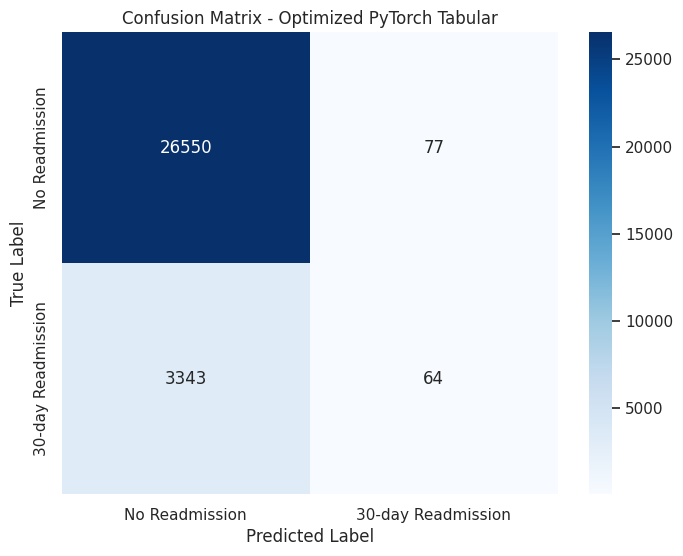

In [39]:
# Save the final PyTorch Tabular model
print("Saving PyTorch Tabular model...")

# Save the model
model_save_path = "best_pytorch_tabular_model"
final_model_pt.save_model(model_save_path)

# Also save the best hyperparameters
with open("best_pytorch_tabular_params.txt", "w") as f:
    f.write("Best PyTorch Tabular Hyperparameters:\n")
    f.write("="*50 + "\n")
    for key, value in study_pt.best_params.items():
        f.write(f"{key}: {value}\n")
    f.write(f"\nBest CV Accuracy Score: {study_pt.best_value:.4f}\n")
    f.write(f"Final Test Accuracy Score: {final_accuracy_pt:.4f}\n")
    f.write(f"Final Test F1 Score: {final_f1_pt:.4f}\n")
    f.write(f"Final Test ROC-AUC: {final_auc_pt:.4f}\n")

print("Model and parameters saved successfully")

# Create confusion matrix for PyTorch Tabular
cm_pt = confusion_matrix(y_test_pt, final_pred_pt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_pt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Readmission', '30-day Readmission'], 
            yticklabels=['No Readmission', '30-day Readmission'])
plt.title('Confusion Matrix - Optimized PyTorch Tabular')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
# save plot
plt.savefig('confusion_matrix_optimized_pytorch_tabular.png')

print(f"\nConfusion Matrix (PyTorch Tabular):")
print(f"True Negatives: {cm_pt[0,0]}")
print(f"False Positives: {cm_pt[0,1]}")
print(f"False Negatives: {cm_pt[1,0]}")
print(f"True Positives: {cm_pt[1,1]}")

 * The results have slightly worse accuracy than in XGBOOST method. However, the higher recall makes it relatively safer to implement.

In [40]:
# Compare XGBoost and PyTorch Tabular results
print("="*60)
print("MODEL COMPARISON: XGBoost vs PyTorch Tabular")
print("="*60)

# print("\nCross-Validation Results (4-fold accuracy scores):")
# print(f"XGBoost CV Accuracy:         {final_cv_scores.mean():.3f} ± {final_cv_scores.std():.3f}")
# print(f"PyTorch Tabular CV Accuracy: {np.mean(final_cv_scores_pt):.3f} ± {np.std(final_cv_scores_pt):.3f}")

print(f"\nTest Set Performance:")
print(f"{'Metric':<15} {'XGBoost':<10} {'PyTorch Tabular':<15}")
print("-" * 40)
print(f"{'Accuracy':<15} {test_accuracy:.3f}      {final_accuracy_pt:.3f}")
print(f"{'Precision':<15} {test_precision:.3f}      {final_prec_pt:.3f}")
print(f"{'Recall':<15} {test_recall:.3f}      {final_rec_pt:.3f}")
print(f"{'F1':<15} {test_f1:.3f}      {final_f1_pt:.3f}")
print(f"{'ROC-AUC':<15} {test_auc:.3f}      {final_auc_pt:.3f}")

print(f"\nBest Hyperparameters:")
print(f"\nXGBoost:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")
    
print(f"\nPyTorch Tabular:")
for key, value in study_pt.best_params.items():
    print(f"  {key}: {value}")

print("\n" + "="*60)

MODEL COMPARISON: XGBoost vs PyTorch Tabular

Test Set Performance:
Metric          XGBoost    PyTorch Tabular
----------------------------------------
Accuracy        0.885      0.886
Precision       0.444      0.454
Recall          0.053      0.019
F1              0.095      0.036
ROC-AUC         0.785      0.736

Best Hyperparameters:

XGBoost:
  n_estimators: 819
  max_depth: 9
  learning_rate: 0.01571828607328239
  subsample: 0.8938118110509764
  colsample_bytree: 0.7794007533822664
  reg_alpha: 0.7725486940264297
  reg_lambda: 0.5566573335642219

PyTorch Tabular:
  layers_depth: 3
  layer_size: 512
  dropout: 0.19888689412989274
  learning_rate: 0.00016952317534841183
  batch_size: 1024
  activation: ReLU
  balance_strategy: class_weights



 * While the accuracy is good, its low recall might make the model unsuitable for deployment yet.

 ## Model interpretation

 * We will use SHAP, a model-agnostic technique to analyze feature contributions the the output.

Performing SHAP analysis on the optimized XGBoost model...
SHAP values computed for 5000 samples


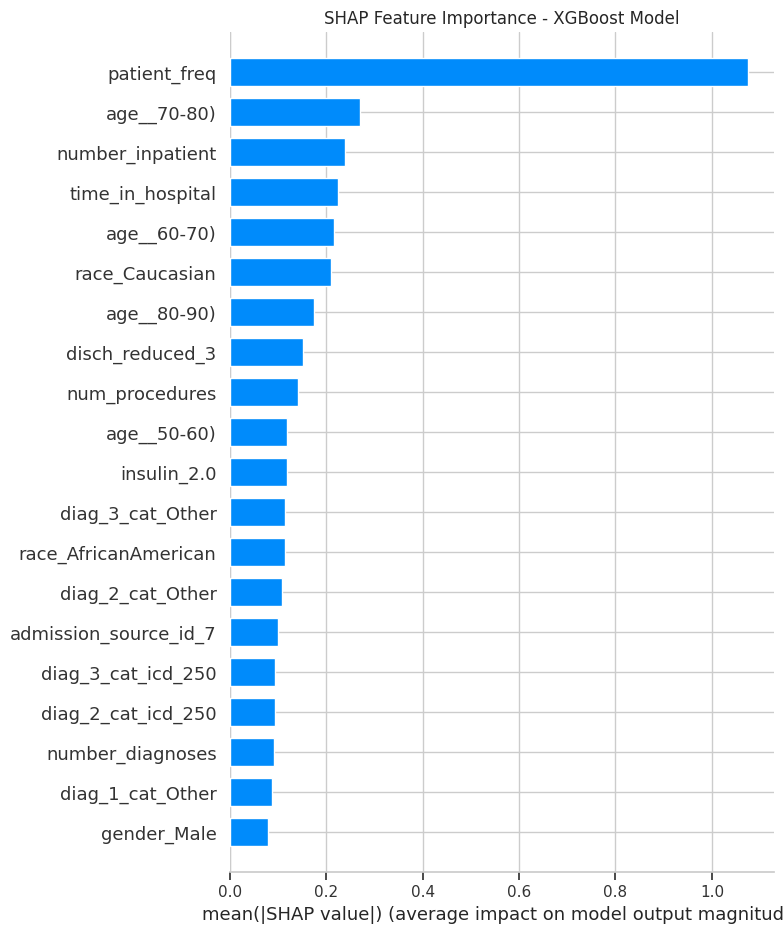

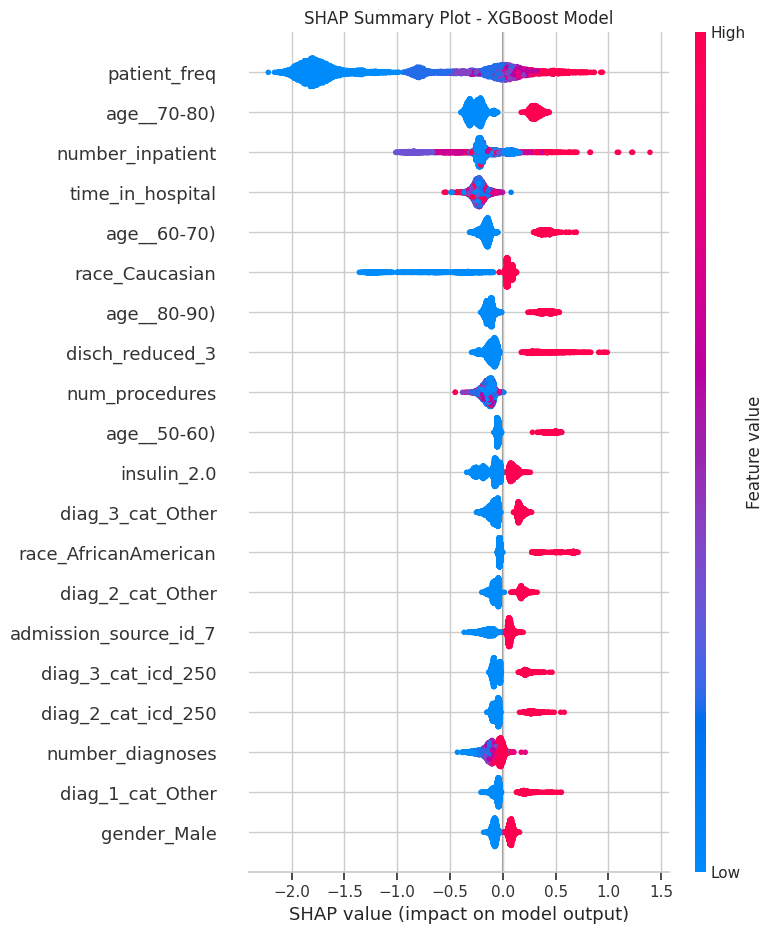


Top 15 Most Important Features (SHAP):
                   feature  importance
8             patient_freq    1.075111
29             age__70-80)    0.269196
6         number_inpatient    0.239128
0         time_in_hospital    0.224778
28             age__60-70)    0.216740
18          race_Caucasian    0.210836
30             age__80-90)    0.174531
10         disch_reduced_3    0.151605
2           num_procedures    0.141517
27             age__50-60)    0.118202
187            insulin_2.0    0.118202
499       diag_3_cat_Other    0.115247
16    race_AfricanAmerican    0.115199
350       diag_2_cat_Other    0.107797
44   admission_source_id_7    0.100573


In [41]:
# SHAP Analysis for XGBoost Model
print("Performing SHAP analysis on the optimized XGBoost model...")

# Get the XGBoost classifier from the best pipeline
xgb_model = best_pipeline.named_steps['classifier']

# Use a sample of training data for SHAP (to speed up computation)
sample_size = 5000
sample_indices = np.random.choice(X_test.shape[0], size=min(sample_size, X_test.shape[0]), replace=False)
X_sample = X_test.iloc[sample_indices]

# Create SHAP explainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_sample)

print(f"SHAP values computed for {len(X_sample)} samples")

# Summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title('SHAP Feature Importance - XGBoost Model')
plt.tight_layout()
plt.show()

# Detailed summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title('SHAP Summary Plot - XGBoost Model')
plt.tight_layout()
plt.show()

# Feature importance ranking
feature_importance = np.abs(shap_values).mean(0)
feature_names = X_sample.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features (SHAP):")
print(importance_df.head(15))

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import log_loss, make_scorer
from sklearn.base import BaseEstimator, ClassifierMixin

class ModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, categorical_cols=None, original_df=None):
        self.model = model
        self._estimator_type = "classifier"
        self.classes_ = np.array([0, 1])
        
        # Store categorical columns and original dataframe for reference
        self.categorical_cols = categorical_cols
        
        # Store original_df without target column to avoid KeyError
        if original_df is not None and 'target' in original_df.columns:
            self.original_df = original_df.drop(columns=['target'])
        else:
            self.original_df = original_df
        
        # Create a one-hot encoder for use with permutation importance
        if categorical_cols and self.original_df is not None:
            self.onehot_df = pd.get_dummies(self.original_df, 
                                           columns=categorical_cols, 
                                           drop_first=False)
            # Create mapping from one-hot encoded columns back to original
            self.onehot_cols = self.onehot_df.columns.tolist()
    
    def _convert_to_original_format(self, X):
        """Convert one-hot encoded dataframe back to original format with categorical columns"""
        # If the input already has the same format as original_df, return it
        if self.original_df is None:
            return X.copy()
            
        if set(X.columns).issubset(set(self.original_df.columns)):
            return X.copy()
            
        # Start with numerical columns that are in both dataframes
        common_cols = [col for col in self.original_df.columns 
                      if col not in self.categorical_cols and col in X.columns]
        
        # Create a new dataframe with the common columns
        original_format = X[common_cols].copy()
        
        # For each categorical column, find its one-hot columns and convert back
        for cat_col in self.categorical_cols:
            # Find one-hot columns for this category
            onehot_prefix = f"{cat_col}_"
            related_cols = [col for col in X.columns if col.startswith(onehot_prefix)]
            
            # Skip if no one-hot columns found for this category
            if not related_cols:
                continue
                
            # Get the original categories from the column names
            categories = [col.replace(onehot_prefix, "") for col in related_cols]
            
            # For each row, find the column with max value and assign the category
            cat_values = []
            for _, row in X[related_cols].iterrows():
                if row.sum() > 0:  # If any one-hot column is active
                    max_idx = row.values.argmax()
                    cat_values.append(categories[max_idx])
                else:
                    # If no one-hot column is active, use the most common category
                    cat_values.append(self.original_df[cat_col].mode()[0])
            
            # Add the categorical column to the result
            original_format[cat_col] = cat_values
            
        return original_format
    
    def predict(self, X):
        """Return class predictions (0 or 1)"""
        # Convert X to original format if needed
        if self.categorical_cols is not None:
            X_orig = self._convert_to_original_format(X)
        else:
            X_orig = X
            
        preds = self.model.predict(X_orig)
        return (preds["target_1_probability"].values > 0.5).astype(int)
    
    def predict_proba(self, X):
        """Return probability predictions for both classes"""
        # Convert X to original format if needed
        if self.categorical_cols is not None:
            X_orig = self._convert_to_original_format(X)
        else:
            X_orig = X
            
        preds = self.model.predict(X_orig)
        prob_0 = preds["target_0_probability"].values
        prob_1 = preds["target_1_probability"].values
        return np.column_stack([prob_0, prob_1])

    def fit(self, X, y):
        # Required by sklearn but we don't need to do anything
        self.classes_ = np.unique(y)
        return self

def custom_log_loss(y_true, y_pred_proba):
    return -log_loss(y_true, y_pred_proba)

# Get categorical columns
categorical_cols_pt = [col for col in test_df_pt.columns 
                      if test_df_pt[col].dtype == 'object' or 
                      str(test_df_pt[col].dtype) == 'category']

# Create one-hot encoded version of test dataframe for permutation importance
test_df_pt_onehot = pd.get_dummies(test_df_pt, 
                                   columns=categorical_cols_pt, 
                                   drop_first=False)

# Create the wrapper with categorical information - pass complete test_df_pt
# The wrapper will handle dropping target column internally
wrapped_model = ModelWrapper(
    model=final_model_pt,
    categorical_cols=categorical_cols_pt,
    original_df=test_df_pt
)

# Run permutation importance on the one-hot encoded data (without target column)
result = permutation_importance(
    wrapped_model, 
    test_df_pt_onehot.drop(columns=['target']), 
    y_test_pt, 
    scoring='accuracy', 
    n_repeats=20, 
    random_state=1803
)

In [ ]:
# from sklearn.inspection import permutation_importance
# from sklearn.metrics import log_loss, make_scorer
# from sklearn.base import BaseEstimator, ClassifierMixin

# class ModelWrapper(BaseEstimator, ClassifierMixin):
#     def __init__(self, model):
#         self.model = model
#         # Explicitly set estimator type
#         self._estimator_type = "classifier"
#         # Set classes_ attribute to indicate this is a binary classifier
#         self.classes_ = np.array([0, 1])
    
#     def predict(self, X):
#         """Return class predictions (0 or 1)"""
#         preds = self.model.predict(X)
#         # Convert probabilities to binary class predictions
#         return (preds["target_1_probability"].values > 0.5).astype(int)
    
#     def predict_proba(self, X):
#         """Return probability predictions for both classes"""
#         preds = self.model.predict(X)
#         # Return probabilities for both classes
#         prob_0 = preds["target_0_probability"].values
#         prob_1 = preds["target_1_probability"].values
#         return np.column_stack([prob_0, prob_1])

#     def fit(self, X, y):
#         # Required by sklearn but we don't need to do anything
#         self.classes_ = np.unique(y)
#         return self

# def custom_log_loss(y_true, y_pred_proba):
#     return -log_loss(y_true, y_pred_proba)

# custom_scorer = make_scorer(custom_log_loss, response_method='predict', greater_is_better=True)

# # Create the wrapper
# wrapped_model = ModelWrapper(final_model_pt)

# result = permutation_importance(wrapped_model, test_df_pt, y_test_pt, scoring='accuracy', n_repeats=20, random_state=1803)
# importance_df = pd.DataFrame({
#     'feature': train_df_pt.columns,
#     'importance': result.importances_mean
# }).sort_values(by='importance', ascending=False)

In [ ]:
result.head(15).plot(kind='barh', x='feature', y='importance', figsize=(12, 8), legend=False)
plt.title('Permutation Feature Importance - PyTorch Tabular Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
print("\nTop 15 Most Important Features (Permutation Importance - PyTorch Tabular):")
print(importance_df.head(15))

In [ ]:
result_xgboost = permutation_importance(xgb_model, X_test, y_test, scoring='accuracy', n_repeats=10, random_state=1803)

In [ ]:
importance_df_xgboost = pd.DataFrame({
    'feature': X_train.columns,
    'importance': result_xgboost.importances_mean
}).sort_values(by='importance', ascending=False)

print("\nTop 15 Most Important Features (Permutation Importance - XGBoost):")
print(importance_df_xgboost.head(15))

In [ ]:
importance_df_xgboost.head(15).plot(kind='barh', x='feature', y='importance', figsize=(12, 8), legend=False)
plt.title('Permutation Feature Importance - XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

 ### As of now we will not be implementing SHAP on the Pytorch Model as I am encountering compatibility issues between SHAP and Pytorch Tabular model.

In [ ]:
# Reload the best PyTorch Tabular model
# print("Reloading the best PyTorch Tabular model...")

# # Load the saved model
# final_model_pt = TabularModel.load_model("best_pytorch_tabular_model")

# print("Model reloaded successfully!")

In [ ]:
# train_df_pt_float = train_df_pt.astype(np.float32)
# # keep the feature order you trained with
# FEATURE_NAMES = train_df_pt_float.columns.tolist()

# def pytorch_tabular_predict_proba(X):
#     """
#     SHAP wrapper for PyTorch-Tabular.
#     Ensures the incoming object is a pandas.DataFrame
#     with the correct column names and dtypes.
#     Returns the positive-class probability reshaped for SHAP.
#     """

#     pred_proba = final_model_pt.predict(X)

#     # keep only P(y=1) and give SHAP a 2-D array
#     return pred_proba["target_1_probability"].to_numpy().reshape(-1, 1)

# # ───  A.  Summarise the background  ────────────────────────────────────────────

# dense_bg   = shap.kmeans(train_df_pt_float, k=100)             # DenseData (not callable)
# masker     = shap.maskers.Independent(dense_bg.data)    # <-- make it callable

In [ ]:
# # ───  B.  Build the explainer  ────────────────────────────────────────────────
# explainer_pt = shap.Explainer(
#     pytorch_tabular_predict_proba,  # returns *logits*, see previous answer
#     masker,
#     link=shap.links.logit,                   # tell SHAP what the wrapper outputs
#     algorithm="permutation"         # same default the auto-chooser would pick
# )

In [ ]:
# # ───  C.  Explain a subset  ───────────────────────────────────────────────────

# sample_size     = 500
# sample_indices  = np.random.choice(len(train_df_pt_float),
#                                    size=min(sample_size, len(train_df_pt_float)),
#                                    replace=False)

# X_sample_pt     = train_df_pt_float.iloc[sample_indices]
# shap_values_pt = explainer_pt(X_sample_pt, max_evals=1300)

In [ ]:
# shap.summary_plot(shap_values_pt.values, features=X_sample_pt,
#                   feature_names=X_sample_pt.columns, show=False)

In [ ]:
# # Feature importance ranking for PyTorch Tabular
# feature_importance_pt = np.abs(shap_values_pt).mean(0)
# feature_names_pt = X_sample_pt.columns
# importance_df_pt = pd.DataFrame({
#     'feature': feature_names_pt,
#     'importance': feature_importance_pt.ravel()
# }).sort_values('importance', ascending=False)

# print("\nTop 60 Most Important Features (SHAP - PyTorch Tabular):")
# importance_df_pt.head(60).to_csv('pytorch_tabular_shap_importance.csv', index=False)


